In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%pylab qt5

Populating the interactive namespace from numpy and matplotlib


In [3]:
%matplotlib qt5

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 5.0)

In [3]:
from res_manager import ResultManager

In [4]:
rm = ResultManager('evaluation_results')

In [5]:
rm.print_meta_info()

+---------+----------------------------------+--------------+-------------+----------+
| Data ID |               Name               |    Topic     |     Type    | Versions |
+---------+----------------------------------+--------------+-------------+----------+
|    1    |   Robustness_JPEG_InceptionV3    |   Dataset    | defaultdict |    1     |
|    2    |   Performance_JPEG_InceptionV3   | Performance  | defaultdict |    1     |
|    3    |    Banchmark_JPEG_InceptionV3    |  Banchmark   | defaultdict |    1     |
|    4    |     Banchmark_JPEG_ResNet50      |  Banchmark   | defaultdict |    2     |
|    5    |     Robustness_JPEG_ResNet50     |   Dataset    | defaultdict |    1     |
|    6    |  train_evaluate_baidu_imagenet   |  AgentTrain  | defaultdict |    1     |
|    7    |     evaluate_baidu_imagenet      |  AgentTrain  | defaultdict |    1     |
|    8    |      train_facepp_imagenet       |  AgentTrain  | defaultdict |    1     |
|    9    |     evaluate_facepp_imagenet   

### overall latency data

In [8]:
DNIM_agent_on_imagenet = rm.load(23)

In [9]:
DNIM_agent_on_imagenet.keys()

dict_keys(['status', 'accuracy', 'recent_accuracy', 'action', 'upload_size', 'reward', 'image_path', 'comp_size', 'step_count', 'agent_accuracy', 'agent_epsilon', 'size_reward', 'recent_reward', 'ref_size'])

In [26]:
np.mean(DNIM_agent_on_imagenet['ref_size'][-2000:])

42680.2783919598

In [18]:
np.mean(DNIM_agent_on_imagenet['comp_size'][-700:])

18467.824285714287

# Old codes, run on InceptionV3

## Performance on JPEG and InceptionV3

In [5]:
accuracies = rm.load(3)['accuracies']
sizes = rm.load(3)['sizes']
qualities = rm.load(3)['qualities']
errors = 1. - np.array(accuracies)

In [6]:
performance = rm.load(2)

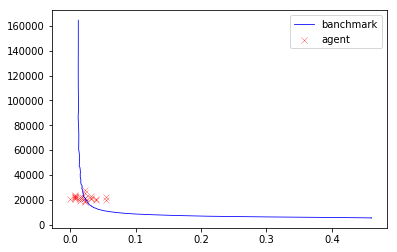

In [7]:
plot(errors, sizes, c='b', linewidth=0.8, label="banchmark")
scatter(1. - np.array(performance['batch_accuracies']), performance['batch_sizes'], marker='x', linewidth=0.3, c='r', label='agent')
legend()

In [8]:
performance.keys()

dict_keys(['banchmark_sizes', 'agent_sizes', 'batch_accuracies', 'batch_sizes'])

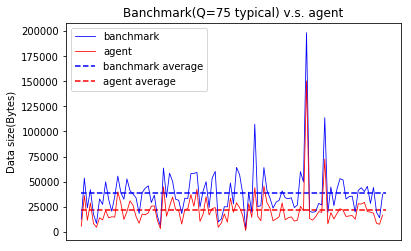

In [9]:
plot_count = 100
plot(performance['banchmark_sizes'][:plot_count], c='b', linewidth=0.8, label='banchmark')
plot(performance['agent_sizes'][:plot_count], c='r', linewidth=0.8, label='agent')
hlines(xmin=0, xmax=plot_count, y=np.mean(performance['banchmark_sizes']), color='b', linestyles='--', label="banchmark average")
hlines(xmin=0, xmax=plot_count, y=np.mean(performance['agent_sizes']), color='r', linestyles='--', label="agent average")
title("Banchmark(Q=75 typical) v.s. agent")
ylabel("Data size(Bytes)")
xticks([])
legend()

In [10]:
print(np.mean(performance['batch_accuracies']))

0.9777715773809524


## Generate banchmark & robustness training set

In [5]:
from keras.applications import ResNet50
from keras.utils.np_utils import to_categorical
from imagenet import imagenet_label2class
from keras.applications.resnet50 import preprocess_input
import os
from io import BytesIO
from collections import defaultdict
from PIL import Image

Using TensorFlow backend.


In [6]:
def gen_sample_set(imagenet_data_path, samples_per_class):
    image_paths = []
    image_labels = []

    img_classes = os.listdir(imagenet_data_path)
    for img_class in img_classes:
        for image_name in np.random.choice(os.listdir("%s/%s" % (imagenet_data_path, img_class)),
                                           size=samples_per_class):
            sample_image_path = ("%s/%s/%s" % (imagenet_data_path, img_class, image_name))
            image_label = imagenet_label2class[image_name.split('_')[0]]

            image_paths.append(sample_image_path)
            image_labels.append(image_label)
    return image_paths, image_labels

def compress_Q(img, Q):
    f = BytesIO()
    img.save(f, format="JPEG", quality=Q)
    size = len(f.getvalue())
    return Image.open(f), size

def max_continous_idx(l):
    sums = []
    ids = []
    curr_sum = 0
    for idx, item in enumerate(l):
        if item == 1:
            curr_sum += 1
            if curr_sum == len(l):
                return len(l) - 1
        else:
            sums.append(curr_sum)
            curr_sum = 0
            ids.append(idx -  1)
    return np.array(ids)[np.argmax(sums)]

In [7]:
sample_paths, sample_labels = gen_sample_set('/home/hsli/gnode02/imagenet-data/train/', 5)

In [8]:
model_labels = to_categorical(sample_labels, 1000)

In [9]:
model = ResNet50()
model.compile('adam', 'categorical_crossentropy', ['top_k_categorical_accuracy'])

In [10]:
robust_dict = defaultdict(list)
measurement_dict = defaultdict(list)
banchmark = defaultdict(list)
for idx, path in enumerate(sample_paths):
    if idx % 100 == 0:
        print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), end='\t')
        print(idx)
    model_label = np.expand_dims(model_labels[idx], axis=0)
    top5_list = []
    size_list = []
    img = Image.open(path).convert("RGB")
    for i in arange(100, 0, -1):
        compressed_img, size = compress_Q(img, int(i))
        model_input_data = preprocess_input(np.expand_dims(np.asarray(compressed_img.resize((224, 224)), dtype=np.float32), axis=0))
        loss, top5 = model.evaluate(model_input_data, model_label, verbose=0)
        top5_list.append(int(top5))
        size_list.append(size)
    minimal_stable_q = 100 - max_continous_idx(top5_list)
    measurement_dict['paths'].append(path)
    measurement_dict['top5_upon_q'].append(top5_list)
    measurement_dict['minimal_stable_q'].append(minimal_stable_q)
    measurement_dict['size_lists'].append(size_list)
    
    if minimal_stable_q < 100:
        robust_dict['paths'].append(path)
        robust_dict['robustness'].append(minimal_stable_q)
    

2019-03-04 21:53:46	0
2019-03-04 21:57:43	100
2019-03-04 22:01:34	200
2019-03-04 22:05:19	300
2019-03-04 22:09:21	400
2019-03-04 22:13:22	500
2019-03-04 22:17:50	600
2019-03-04 22:21:47	700
2019-03-04 22:25:40	800
2019-03-04 22:29:29	900
2019-03-04 22:33:05	1000
2019-03-04 22:37:05	1100
2019-03-04 22:41:04	1200
2019-03-04 22:44:46	1300
2019-03-04 22:49:05	1400
2019-03-04 22:52:47	1500
2019-03-04 22:56:50	1600
2019-03-04 23:01:13	1700
2019-03-04 23:05:00	1800
2019-03-04 23:09:00	1900
2019-03-04 23:12:53	2000
2019-03-04 23:17:17	2100
2019-03-04 23:21:04	2200
2019-03-04 23:24:51	2300
2019-03-04 23:29:05	2400
2019-03-04 23:32:52	2500
2019-03-04 23:37:12	2600
2019-03-04 23:40:59	2700
2019-03-04 23:44:51	2800
2019-03-04 23:48:32	2900
2019-03-04 23:52:29	3000
2019-03-04 23:56:16	3100
2019-03-05 00:00:28	3200
2019-03-05 00:04:12	3300
2019-03-05 00:08:04	3400
2019-03-05 00:12:24	3500
2019-03-05 00:16:42	3600
2019-03-05 00:20:27	3700
2019-03-05 00:24:21	3800
2019-03-05 00:28:08	3900
2019-03-05 0

In [11]:
top5_data = np.array(measurement_dict['top5_upon_q'])
top5_upon_q_list = []
for i in range(100):
    top5_upon_q_list.append(sum(top5_data[:, i]) / len(top5_data[:, i]))

In [12]:
banchmark['accuracies'] = top5_upon_q_list[::-1]
banchmark['qualities'] = [i+1 for i in range(100)]
banchmark['sizes'] = np.mean(np.array(measurement_dict['size_lists']), axis=0)[::-1].tolist()

In [13]:
rm.save(banchmark, name="Banchmark_JPEG_ResNet50", topic="Banchmark", comment="accuracies and sizes upon each Q, JPEG and ResNet50 on 5K")

In [14]:
rm.save(robust_dict, name="Robustness_JPEG_ResNet50", topic="Dataset", comment="robust dataset for JPEG and ResNet50(top-5)")

## Time evaluation

In [26]:
from keras.applications import MobileNetV2

In [27]:
model = MobileNetV2()

In [28]:
start = time.time()

In [29]:
def inference():
    for i in range(10):
        model.predict(np.ones((1, 224, 224, 3)))
    print(time.time() - start)

In [30]:
%time inference()

11.993841409683228
CPU times: user 1.25 s, sys: 3.75 ms, total: 1.25 s
Wall time: 1.24 s


In [20]:
from keras.applications import InceptionV3

In [21]:
model = InceptionV3()

In [22]:
start = time.time()

In [24]:
def inference():
    for i in range(10):
        model.predict(np.ones((1, 224, 224, 3)))
    print(time.time() - start)

In [25]:
%time inference()

30.906505823135376
CPU times: user 212 ms, sys: 40.8 ms, total: 253 ms
Wall time: 231 ms


## Epsilon decay curve

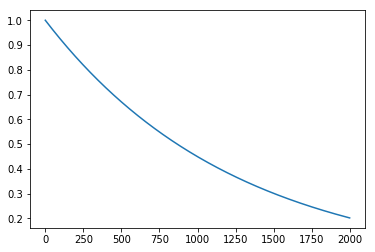

In [15]:
plot([0.9992 ** i for i in range(2000)])

## Does the micro acc_r indicates the macro accuracy?

In [5]:
# encoding: utf-8
import tensorflow as tf
from res_manager import ResultManager
import numpy as np
from collections import defaultdict

from keras.applications.mobilenetv2 import preprocess_input
from keras.applications import InceptionV3

from Agents import DDPG_Agent, Q_Agent
from keras.models import load_model
from ImageCompressionEnvironment import Environment

np.set_printoptions(precision=3)

tf.set_random_seed(2)
np.random.seed(2)

Using TensorFlow backend.


In [6]:
images_dir = '/home/hsli/imagenet-data/train/'

feature_extractor = load_model(
    'checkpoints/mobilenetv2_predictor_2W_acc_0.6955_epoch50.hdf5')

rm = ResultManager('results')
agent_acc_size_dict = []
origin_acc_size_dict = []

agent = Q_Agent(s_dim=2,
                a_dim=10,
                epsilon_decay=0.9993,
                epsilon_min=0.2,
                lr=0.1,
                gamma=0.95)

step_count = 0

env = Environment(imagenet_train_path=images_dir,
                  samples_per_class=1000,
                  backbone_model=InceptionV3(),
                  backbone_model_input_size=(299, 299))

1000/1000 [==============================] - 8s 8ms/step
Reference soft labels generated..


In [7]:
from collections import defaultdict

In [8]:
result = defaultdict(list)
for idx, image in enumerate(env.image_datalist):
    print(idx, end=', ')
    accr_list = []
    sizer_list = []
    for q in np.arange(100, 0, -1):
        acc_r, size_r = env.model_recognize(image, 
                                            int(q),
                                            env.label_datalist[idx],
                                            env.ref_softlabels[idx],
                                            env.ref_size_list[idx])
        accr_list.append(acc_r)
        sizer_list.append(size_r)
    result['acc'].append(accr_list)
    result['size'].append(sizer_list)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

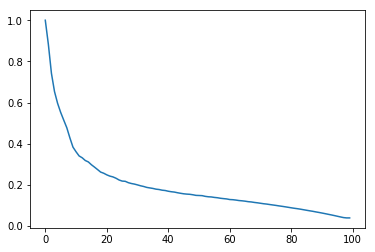

In [9]:
plot(np.mean(np.array(result['size']), axis=0))

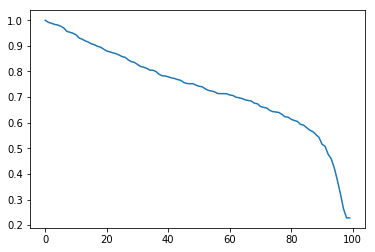

In [13]:
plot(np.mean(np.array(result['acc']), axis=0))

In [14]:
np.mean(np.array(result['acc']), axis=0)

array([1.   , 0.992, 0.988, 0.984, 0.981, 0.977, 0.97 , 0.957, 0.953,
       0.949, 0.943, 0.931, 0.926, 0.919, 0.915, 0.908, 0.904, 0.898,
       0.895, 0.887, 0.88 , 0.877, 0.873, 0.87 , 0.864, 0.858, 0.855,
       0.845, 0.838, 0.835, 0.827, 0.82 , 0.817, 0.812, 0.805, 0.805,
       0.8  , 0.789, 0.783, 0.782, 0.779, 0.775, 0.773, 0.769, 0.766,
       0.757, 0.753, 0.752, 0.752, 0.747, 0.742, 0.74 , 0.733, 0.726,
       0.724, 0.721, 0.714, 0.713, 0.714, 0.713, 0.708, 0.706, 0.7  ,
       0.697, 0.694, 0.689, 0.687, 0.685, 0.676, 0.674, 0.663, 0.66 ,
       0.658, 0.648, 0.643, 0.642, 0.64 , 0.632, 0.623, 0.622, 0.613,
       0.609, 0.605, 0.593, 0.59 , 0.581, 0.571, 0.565, 0.554, 0.543,
       0.516, 0.508, 0.477, 0.459, 0.424, 0.375, 0.322, 0.264, 0.228,
       0.228], dtype=float32)

# Evaluate on cloud services

## Baidu Vision, ImageNet 1.6K trials

In [16]:
def list_split(l, size):
    return [l[m:m + size] for m in range(0, len(l), size)]

In [48]:
def front_acc(accs):
    acc_list = []
    temp_list = [np.mean(accs[5:15])]
    for acc in accs:
        temp_list.append(acc)
        acc_list.append(np.sum(temp_list) / len(temp_list))
    return acc_list

In [49]:
baidu_trainlog = rm.load(6)
baidu_evallog = rm.load(7)

In [50]:
baidu_trainlog.keys()
baidu_evallog.keys()

dict_keys(['reward', 'image_path', 'size_r', 'epsilon', 'action', 'acc_r'])

In [51]:
print(len(baidu_trainlog['reward']), len(baidu_evallog['reward']))

1794 999


### Plot reward, accuracy and compression rate

Text(0.5, 1.0, 'reward = top5_accuracy - compression_rate')

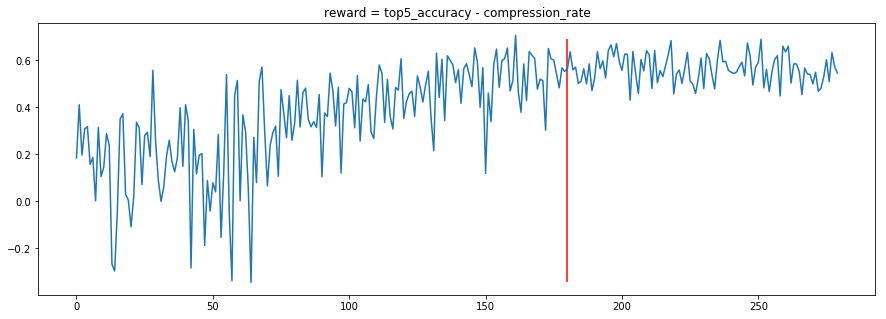

In [52]:
reward_train = [np.mean(item) for item in list_split(baidu_trainlog['reward'], 10)]
reward_eval = [np.mean(item) for item in list_split(baidu_evallog['reward'], 10)]
plot(reward_train + reward_eval)
vlines(x=len(reward_train), ymin=np.min(reward_train), ymax=np.max(reward_eval), colors='r')
title('reward = top5_accuracy - compression_rate')

Text(0.5, 1.0, 'accuracy')

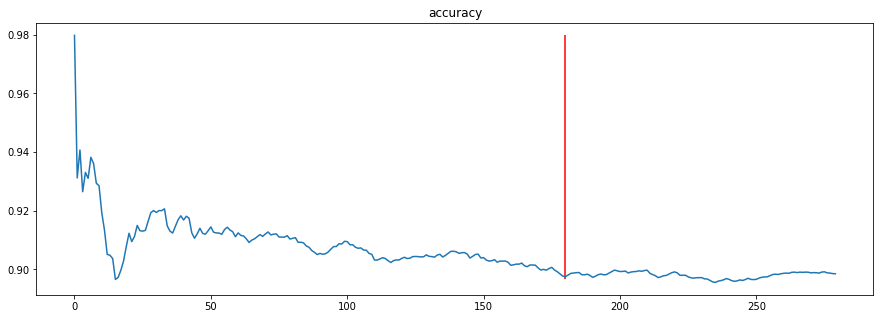

In [54]:
train_real_acc = [0 if item == 0.5 else 1 for item in baidu_trainlog['acc_r']]
eval_real_acc = [0 if item == 0.5 else 1 for item in baidu_evallog['acc_r']]
train_acc_track = front_acc(train_real_acc)
train_acc = [np.mean(item) for item in list_split(train_acc_track, 10)]
overall_acc = [np.mean(item) for item in list_split(front_acc(train_real_acc + eval_real_acc), 10)]
plot(overall_acc)
vlines(x=len(train_acc), ymin=np.min(train_acc), ymax=np.max(train_acc), colors='r')
title('accuracy')

Text(0.5, 1.0, 'compression_rate')

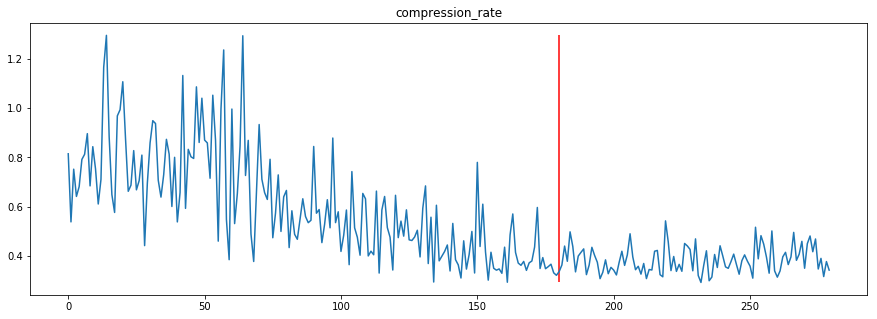

In [29]:
train_size = [np.mean(item) for item in list_split(baidu_trainlog['size_r'], 10)]
eval_size = [np.mean(item) for item in list_split(baidu_evallog['size_r'], 10)]
plot(train_size + eval_size)
vlines(x=len(train_size), ymin=np.min(train_size), ymax=np.max(train_size), color='r')
title('compression_rate')

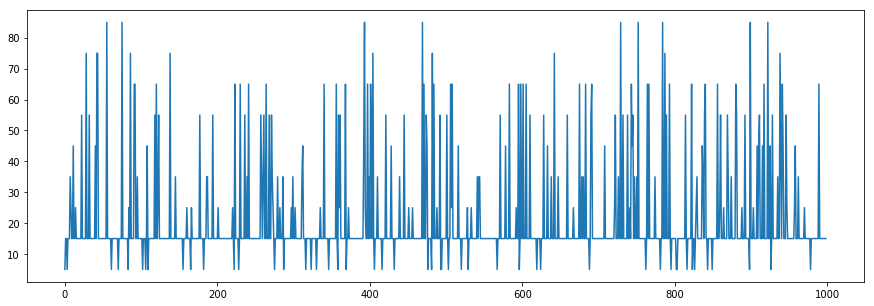

In [30]:
plot(baidu_evallog['action'])

In [14]:
np.mean(baidu_evallog['action'])

20.605605605605607

### Observe images

In [23]:
from PIL import Image

In [28]:
high_q_ids = np.where(np.array(baidu_evallog['action'])> 65)

chosen_h_ids = np.random.choice(high_q_ids[0], 15, replace=False)

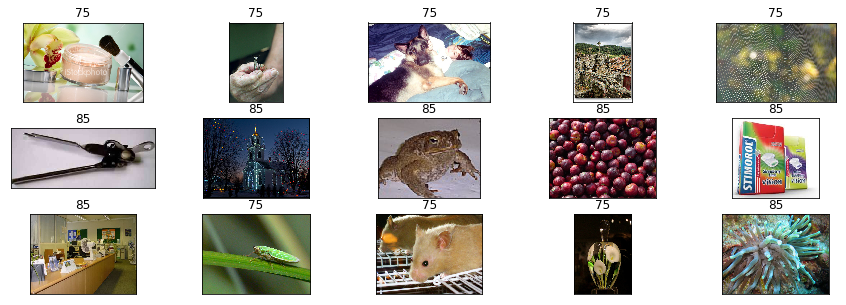

In [40]:
for idx, image_id in enumerate(chosen_h_ids):
    subplot(3, 5, idx+1)
    title(baidu_evallog['action'][image_id])
    imshow(Image.open(baidu_evallog['image_path'][image_id]))
    xticks([])
    yticks([])

In [30]:
low_q_ids = np.where(np.array(baidu_evallog['action']) < 15)

chosen_l_ids = np.random.choice(low_q_ids[0], 15, replace=False)

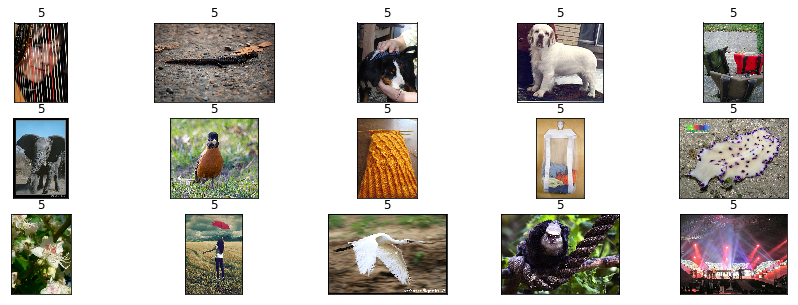

In [41]:
for idx, image_id in enumerate(chosen_l_ids):
    subplot(3, 5, idx+1)
    title(baidu_evallog['action'][image_id])
    imshow(Image.open(baidu_evallog['image_path'][image_id]))
    xticks([])
    yticks([])

## Face++ object detection, ImageNet 1.3K trials

In [6]:
def list_split(l, size):
    return [l[m:m + size] for m in range(0, len(l), size)]

In [7]:
def front_acc(accs):
    acc_list = []
    temp_list = [np.mean(accs[5:15])]
    for acc in accs:
        temp_list.append(acc)
        acc_list.append(np.sum(temp_list) / len(temp_list))
    return acc_list

In [8]:
facepp_trainlog = rm.load(8)
facepp_evallog = rm.load(9)

In [9]:
facepp_trainlog.keys()
facepp_evallog.keys()

dict_keys(['acc_r', 'size_r', 'action', 'reward', 'epsilon', 'image_path'])

In [10]:
print(len(facepp_trainlog['reward']), len(facepp_evallog['reward']))

1200 1200


### Plot reward, accuracy and compression rate

Text(0.5, 1.0, 'reward = top5_accuracy - compression_rate')

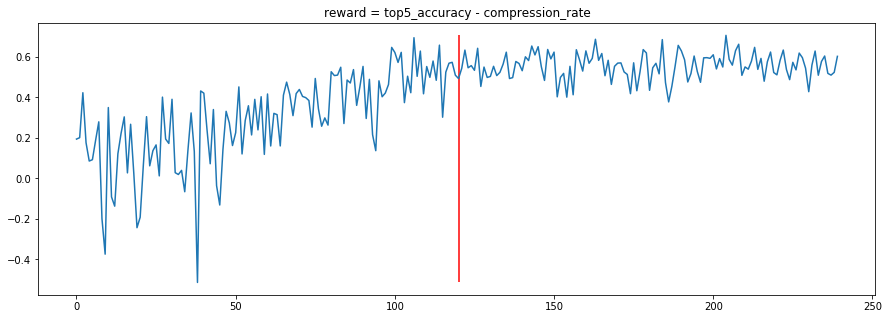

In [36]:
reward_train = [np.mean(item) for item in list_split(facepp_trainlog['reward'], 10)]
reward_eval = [np.mean(item) for item in list_split(facepp_evallog['reward'], 10)]
plot(reward_train + reward_eval)
vlines(x=len(reward_train), ymin=np.min(reward_train), ymax=np.max(reward_eval), colors='r')
title('reward = top5_accuracy - compression_rate')

Text(0.5, 1.0, 'accuracy')

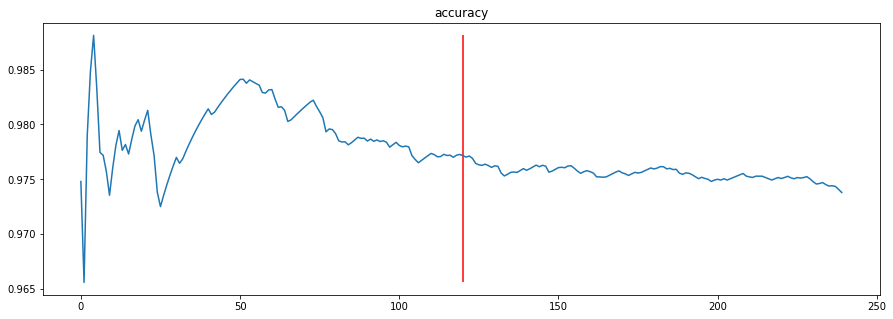

In [37]:
train_acc_track = front_acc(facepp_trainlog['acc_r'])
train_acc = [np.mean(item) for item in list_split(train_acc_track, 10)]
overall_acc = [np.mean(item) for item in list_split(front_acc(facepp_trainlog['acc_r'] + facepp_evallog['acc_r']), 10)]
plot(overall_acc)
vlines(x=len(train_acc), ymin=np.min(train_acc), ymax=np.max(train_acc), colors='r')
title('accuracy')

Text(0.5, 1.0, 'compression_rate')

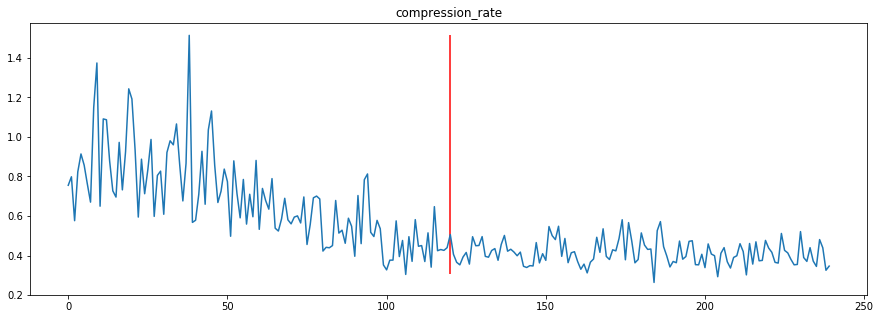

In [38]:
train_size = [np.mean(item) for item in list_split(facepp_trainlog['size_r'], 10)]
eval_size = [np.mean(item) for item in list_split(facepp_evallog['size_r'], 10)]
plot(train_size + eval_size)
vlines(x=len(train_size), ymin=np.min(train_size), ymax=np.max(train_size), color='r')
title('compression_rate')

In [23]:
np.mean(facepp_evallog['action'])

23.483333333333334

### Observe images

In [31]:
from PIL import Image

In [32]:
high_q_ids = np.where(np.array(facepp_evallog['action'])> 65)

chosen_h_ids = np.random.choice(high_q_ids[0], 15, replace=False)

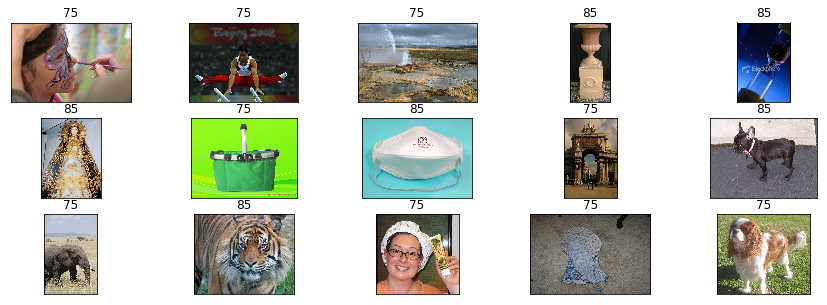

In [33]:
for idx, image_id in enumerate(chosen_h_ids):
    subplot(3, 5, idx+1)
    title(facepp_evallog['action'][image_id])
    imshow(Image.open(facepp_evallog['image_path'][image_id]))
    xticks([])
    yticks([])

In [34]:
low_q_ids = np.where(np.array(facepp_evallog['action']) < 15)

chosen_l_ids = np.random.choice(low_q_ids[0], 15, replace=False)

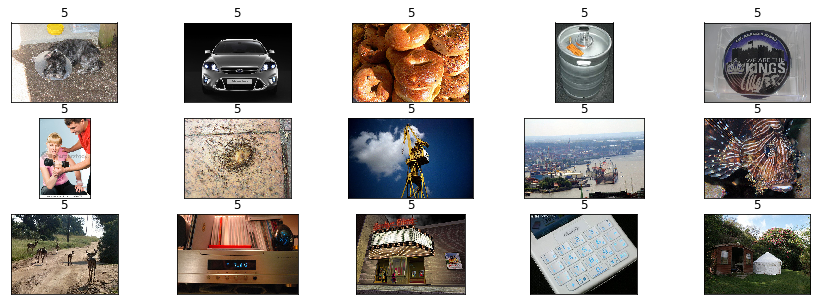

In [35]:
for idx, image_id in enumerate(chosen_l_ids):
    subplot(3, 5, idx+1)
    title(facepp_evallog['action'][image_id])
    imshow(Image.open(facepp_evallog['image_path'][image_id]))
    xticks([])
    yticks([])

## Amazon Rekognition, ImageNet 2K

In [6]:
def list_split(l, size):
    return [l[m:m + size] for m in range(0, len(l), size)]

In [7]:
def front_acc(accs):
    acc_list = []
    temp_list = [np.mean(accs[5:15])]
    for acc in accs:
        temp_list.append(acc)
        acc_list.append(np.sum(temp_list) / len(temp_list))
    return acc_list

In [8]:
amazon_trainlog = rm.load(14)
amazon_evallog = rm.load(15)

In [9]:
amazon_trainlog.keys()
amazon_evallog.keys()

dict_keys(['size_r', 'acc_r', 'epsilon', 'action', 'reward', 'image_path'])

In [10]:
print(len(amazon_trainlog['reward']), len(amazon_evallog['reward']))

1800 1200


### Plot reward, accuracy and compression rate

Text(0.5, 1.0, 'reward = top5_accuracy - compression_rate')

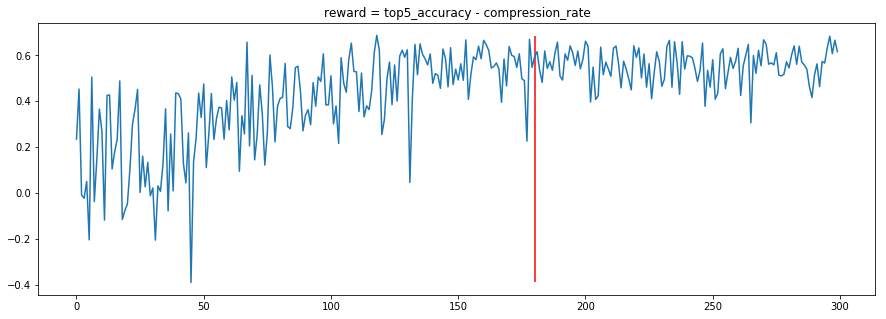

In [11]:
reward_train = [np.mean(item) for item in list_split(amazon_trainlog['reward'], 10)]
reward_eval = [np.mean(item) for item in list_split(amazon_evallog['reward'], 10)]
plot(reward_train + reward_eval)
vlines(x=len(reward_train), ymin=np.min(reward_train), ymax=np.max(reward_eval), colors='r')
title('reward = top5_accuracy - compression_rate')

Text(0.5, 1.0, 'accuracy')

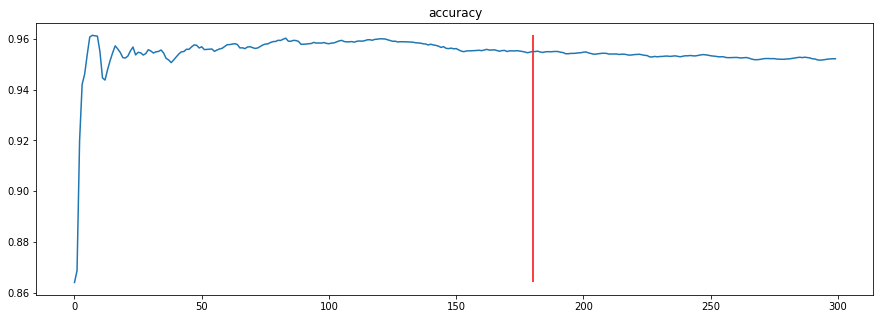

In [12]:
train_acc_track = front_acc(amazon_trainlog['acc_r'])
train_acc = [np.mean(item) for item in list_split(train_acc_track, 10)]
overall_acc = [np.mean(item) for item in list_split(front_acc(amazon_trainlog['acc_r'] + amazon_evallog['acc_r']), 10)]
plot(overall_acc)
vlines(x=len(train_acc), ymin=np.min(train_acc), ymax=np.max(train_acc), colors='r')
title('accuracy')

Text(0.5, 1.0, 'compression_rate')

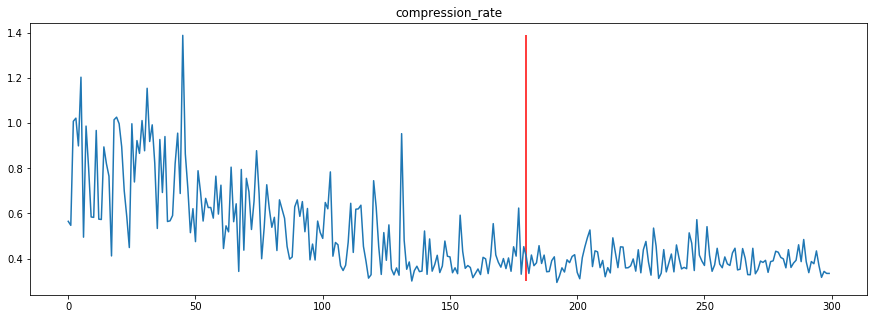

In [13]:
train_size = [np.mean(item) for item in list_split(amazon_trainlog['size_r'], 10)]
eval_size = [np.mean(item) for item in list_split(amazon_evallog['size_r'], 10)]
plot(train_size + eval_size)
vlines(x=len(train_size), ymin=np.min(train_size), ymax=np.max(train_size), color='r')
title('compression_rate')

In [21]:
np.mean(amazon_evallog['action'])

20.833333333333332

### Observe images

In [15]:
from PIL import Image

In [16]:
high_q_ids = np.where(np.array(amazon_evallog['action'])> 65)

chosen_h_ids = np.random.choice(high_q_ids[0], 15, replace=False)

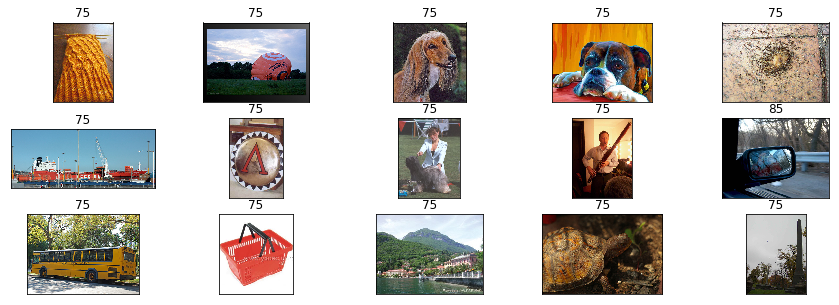

In [18]:
for idx, image_id in enumerate(chosen_h_ids):
    subplot(3, 5, idx+1)
    title(amazon_evallog['action'][image_id])
    imshow(Image.open(amazon_evallog['image_path'][image_id]))
    xticks([])
    yticks([])

In [19]:
low_q_ids = np.where(np.array(amazon_evallog['action']) < 15)

chosen_l_ids = np.random.choice(low_q_ids[0], 15, replace=False)

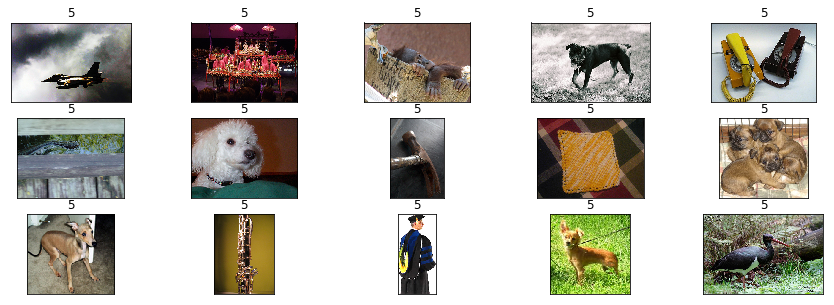

In [20]:
for idx, image_id in enumerate(chosen_l_ids):
    subplot(3, 5, idx+1)
    title(amazon_evallog['action'][image_id])
    imshow(Image.open(amazon_evallog['image_path'][image_id]))
    xticks([])
    yticks([])

## Comparing and ploting

### comparing

In [27]:
from PIL import Image
from io import BytesIO

In [28]:
def compress(image, quality):
    f = BytesIO()
    image.save(f, format='jpeg', quality=quality)
    return Image.open(f)

In [29]:
from cloud_apis import Baidu, FacePP, AmazonRekognition

In [30]:
baidu_evallog = rm.load(7)
facepp_evallog = rm.load(9)
amazon_evallog = rm.load(15)

In [31]:
def list_split(l, size):
    return [l[m:m + size] for m in range(0, len(l), size)]

#### Performance on training phase (train_steps.pdf)

In [218]:
import pickle
with open("evaluation_results/imagenet_baidu_ref2000.pkl", "rb") as f:
    benchmark = pickle.load(f)

In [227]:
benchmark_sizes = [item['ref_size'] for item in benchmark.values()]

baidu_trainlog = rm.load(24)
facepp_trainlog = rm.load(8)
amazon_trainlog = rm.load(14)

baidu_evallog = rm.load(7)
facepp_evallog = rm.load(9)
amazon_evallog = rm.load(15)

In [225]:
len(facepp_evallog['size_r'])

1200

In [230]:
amazon_evallog.keys()

dict_keys(['epsilon', 'action', 'size_r', 'acc_r', 'image_path', 'reward'])

In [232]:
benchmark['/home/hsli/gnode02/imagenet-data/train//n11939491/n11939491_6087.JPEG']

{'error_code': 0,
 'ref_confidence': 0.535516,
 'ref_label': '花卉',
 'ref_size': 25357}

In [233]:
baidu_evalsizes = [baidu_evallog['size_r'][idx] * benchmark[baidu_evallog['image_path'][idx]]['ref_size'] for idx in range(len(baidu_evallog['size_r']))]

In [250]:
baidu_trainsizes = [(1 + baidu_trainlog['size_r'][idx]) * benchmark[baidu_trainlog['image_path'][idx]]['ref_size'] for idx in range(len(baidu_trainlog['size_r']))]
facepp_trainsizes = [(1 + facepp_trainlog['size_r'][idx]) * benchmark[facepp_trainlog['image_path'][idx]]['ref_size'] for idx in range(len(facepp_trainlog['size_r']))]
amazon_trainsizes = [(1 + amazon_trainlog['size_r'][idx]) * benchmark[amazon_trainlog['image_path'][idx]]['ref_size'] for idx in range(len(amazon_trainlog['size_r']))]

baidu_evalsizes = [baidu_evallog['size_r'][idx] * benchmark[baidu_evallog['image_path'][idx]]['ref_size'] for idx in range(len(baidu_evallog['size_r']))]
facepp_evalsizes = [facepp_evallog['size_r'][idx] * benchmark[facepp_evallog['image_path'][idx]]['ref_size'] for idx in range(len(facepp_evallog['size_r']))]
amazon_evalsizes = [amazon_evallog['size_r'][idx] * benchmark[amazon_evallog['image_path'][idx]]['ref_size'] for idx in range(len(amazon_evallog['size_r']))]

baidu_trainsizes = baidu_trainsizes[:1000]
facepp_trainsizes = facepp_trainsizes[:1000]
amazon_trainsizes = amazon_trainsizes[:1000]


In [222]:
len([np.mean(item) for item in list_split(baidu_sizes, 20)])

90

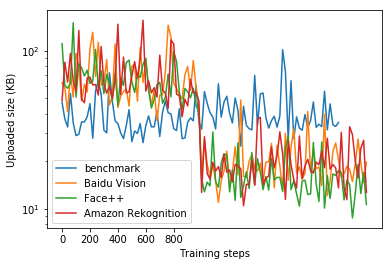

In [256]:
plot([np.mean(item) / 1024. for item in list_split(benchmark_sizes, 20)], label='benchmark')
plot([np.mean(item) / 1024. for item in list_split(baidu_trainsizes + baidu_evalsizes, 20)], label='Baidu Vision')
plot([np.mean(item) / 1024. for item in list_split(facepp_trainsizes + facepp_evalsizes, 20)], label='Face++')
plot([np.mean(item) / 1024. for item in list_split(amazon_trainsizes + amazon_evalsizes, 20)], label='Amazon Rekognition')
xticks([i for i in np.arange(0, 50, 10)], [20 * i for i in np.arange(0, 100, 10)])
# xlim(0, 90)
ylabel("Uploaded size (KB)")
xlabel("Training steps")
yscale('log')
legend()

In [310]:
%matplotlib qt5

In [312]:
baidu_train_sizer = [np.mean(item) for item in list_split(1 + np.array(baidu_trainlog['size_r'][:1000]), 20)]
facepp_train_sizer = [np.mean(item) for item in list_split(1 + np.array(facepp_trainlog['size_r'][:1000]), 20)]
amazon_train_sizer = [np.mean(item) for item in list_split(1 + np.array(amazon_trainlog['size_r'][:1000]), 20)]

baidu_eval_sizer = [np.mean(item) for item in list_split(np.array(baidu_evallog['size_r']), 20)]
facepp_eval_sizer = [np.mean(item) for item in list_split(np.array(facepp_evallog['size_r']), 20)]
amazon_eval_sizer = [np.mean(item) for item in list_split(np.array(amazon_evallog['size_r']), 20)]

plot(baidu_train_sizer + baidu_eval_sizer, label="Baidu")
plot(facepp_train_sizer + facepp_eval_sizer, label="Face++")
plot(amazon_train_sizer + amazon_eval_sizer, label="Amazon Rekognition")

r1 = plt.fill_betweenx(x1=49, x2=49 + len(amazon_eval_sizer), y=[np.min(facepp_eval_sizer),np.max(facepp_train_sizer)], color='bisque', label="Evaluation phase")
r2 = plt.fill_betweenx(x1=0, x2=49, y=[np.min(facepp_eval_sizer),np.max(facepp_train_sizer)], color='powderblue', label="Training phase")

xticks([i for i in np.arange(0, 120, 20)], [20 * i for i in np.arange(0, 120, 20)])
grid()
ylabel("size overhead ($s / s_{\\rm ref}$)")
xlabel("iterations")
# yscale('log')
xlim(0, len(baidu_eval_sizer + baidu_train_sizer))
ylim(np.min(facepp_eval_sizer), np.max(facepp_train_sizer))
legend()

In [317]:
np.mean(rm.load(25)['size_reward'])

0.3590404617286894

In [36]:
%matplotlib qt5

In [304]:
%matplotlib inline

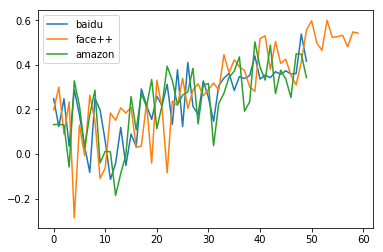

In [305]:
plot([np.mean(item) for item in list_split(baidu_trainlog['reward'], 20)], label='baidu')
plot([np.mean(item) for item in list_split(facepp_trainlog['reward'], 20)], label='face++')
plot([np.mean(item) for item in list_split(amazon_trainlog['reward'], 20)], label='amazon')
legend()

#### Plot performance bars (compress_performance.pdf)

In [69]:
import pickle
with open("evaluation_results/imagenet_baidu_ref2000.pkl", "rb") as f:
    benchmark = pickle.load(f)

In [81]:
size_list = []
for item in benchmark.values():
    try:
        if item['error_code'] == 0:
            size_list.append(item['ref_size'])
    except Exception as e:
        print(e)

'error_code'


In [82]:
np.mean(size_list)

40917.753006012026

In [50]:
benchmark['/home/hsli/gnode02/imagenet-data/train//n01860187/n01860187_3131.JPEG']

{'error_code': 0,
 'ref_confidence': 0.756213,
 'ref_label': '黑天鹅',
 'ref_size': 461887}

In [51]:
benchmark_size = np.mean([item['ref_size'] for item in benchmark.values()]) / 1024.
baidu_size = np.mean(baidu_evallog['size_r']) * benchmark_size
facepp_size = np.mean(facepp_evallog['size_r']) * benchmark_size
amazon_size = np.mean(amazon_evallog['size_r']) * benchmark_size

In [52]:
benchmark_acc = 100.0
baidu_acc = np.mean(np.round(baidu_evallog['acc_r'])) * 100.
facepp_acc = np.mean(np.round(facepp_evallog['acc_r'])) * 100.
amazon_acc = np.mean(np.round(amazon_evallog['acc_r'])) * 100.

In [56]:
%matplotlib qt5

In [53]:
%matplotlib inline

In [18]:
font={'family':'sans-serif',
#      'style':'italic',
#     'weight':'bold',
#       'color':'red',
#       'size':16
}

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)
b11 = ax.bar([1-0.15], [benchmark_size], width=0.3, color='#75bbfd')
ax.text(1-0.15, benchmark_size, "%dKB" % benchmark_size, ha='center', va='top')
b12 = ax.bar([2-0.15], [baidu_size], width=0.3, color='#75bbfd')
ax.text(2-0.15, baidu_size, "%dKB" % baidu_size, ha='center', va='bottom')
b13 = ax.bar([3-0.15], [facepp_size], width=0.3, color='#75bbfd')
ax.text(3-0.15, facepp_size, "%dKB" % facepp_size, ha='center', va='bottom')
b14 = ax.bar([4-0.15], [amazon_size], width=0.3, color='#75bbfd')
ax.text(4-0.15, amazon_size, "%dKB" % amazon_size, ha='center', va='bottom')
ax.set_ylabel("Average size (KB)", fontdict=font)
# ax.set_ylim(0, 45)


ax.grid()
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(["Benchmark Q=75", "Baidu Vision", "Face++", "Amazon Rekognition"], fontdict=font)

ax2 = ax.twinx()
b21 = ax2.bar([1+0.15], [benchmark_acc], label='Average Accuracy', width=0.3, color='#ccad60')
ax2.text(1+0.15, benchmark_acc, "%d%%" % benchmark_acc, ha='center', va='top')
b21 = ax2.bar([2+0.15], [baidu_acc], label='Average Accuracy', width=0.3, color='#ccad60')
ax2.text(2+0.15, baidu_acc, "%.1f%%" % baidu_acc, ha='center', va='top')
b21 = ax2.bar([3+0.15], [facepp_acc], label='Average Accuracy', width=0.3, color='#ccad60')
ax2.text(3+0.15, facepp_acc, "%.1f%%" % facepp_acc, ha='center', va='top')
b21 = ax2.bar([4+0.15], [amazon_acc], label='Average Accuracy', width=0.3, color='#ccad60')
ax2.text(4+0.15, amazon_acc, "%.1f%%" % amazon_acc, ha='center', va='top')
ax2.set_ylabel("Relative Accuracy (%)", fontdict=font)
# ax2.set_ylim(80, 110)


fig.legend([b11, b21], ["Average Size", "Relative Accuracy"], loc=8, ncol=2)

#### Plot selection variation (quality_chosen.pdf)

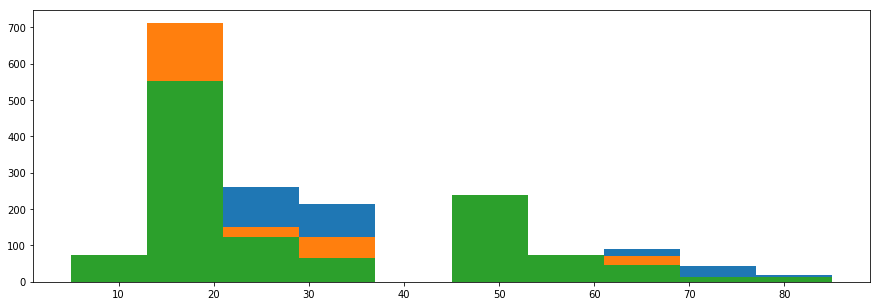

In [32]:
baidu_actions = hist(baidu_evallog['action'], bins=10)
facepp_actions = hist(facepp_evallog['action'], bins=10)
amazon_actions = hist(amazon_evallog['action'], bins=10)

In [36]:
%matplotlib qt5

In [1015]:
%matplotlib inline

In [37]:
bar([i for i in np.arange(5, 105, 10)], np.array(baidu_actions[0]) / 1000, width=3, label='Baidu Vision', color='lightsteelblue')
bar([i - 3 for i in np.arange(5, 105, 10)], np.array(facepp_actions[0]) / 1000, width=3, label='Face++', color='thistle')
bar([i + 3 for i in np.arange(5, 105, 10)], np.array(amazon_actions[0]) / 1000, width=3, label='Amazon Rekognition', color='darksalmon')
xlabel("Compression level (Q for JPEG)")
ylabel(r"Counts ($\times10^3$)")
xticks([i for i in np.arange(5, 105, 10)])
legend()

plt.subplots_adjust(top=1.0,
                    bottom=0.235,
                    left=0.115,
                    right=0.995,
                    hspace=0.2,
                    wspace=0.2)

### Sensetive images

In [498]:
import pickle

In [506]:
with open('evaluation_results/imagenet_amazon_ref2000.pkl', 'rb') as f:
    ref = pickle.load(f)

In [529]:
# sensetive_paths =  np.array(baidu_evallog['image_path'])[np.array([231, 431, 516])]
# facepp_evallog['image_path'][14, 20, 50, 51, 77] # delta q = 20
# sensetive_paths = np.array(facepp_evallog['image_path'])[np.array([50, 72, 77, 296, 528, 586, 705])] # delta q = 5
# path = amazon_evallog['image_path'][408]
# amazon_evallog['image_path'][212, 234] # q=25

In [500]:
baidu = Baidu()
facepp = FacePP()
amazon = AmazonRekognition()
# baidu.recognize(image=img, quality=75)

In [501]:
path = rm.load(7)['image_path'][38]

In [502]:
ref[path]

{'error_code': 0,
 'ref_confidence': 0.948646,
 'ref_label': '办公桌',
 'ref_size': 21596}

In [503]:
img = Image.open(path)
img.show()

简牍 ['Wood'] /home/hsli/gnode02/imagenet-data/train//n04238763/n04238763_18588.JPEG


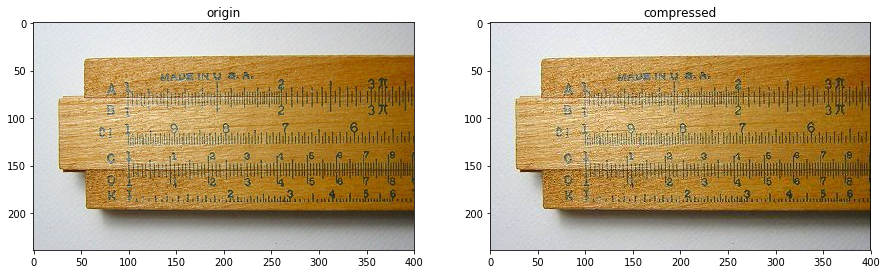

In [78]:
# path = sensetive_paths[0]
img = Image.open(path)
if path in ref.keys():
    gt_result = ref[path]['ref_label']
else:
    error_code, results, size = baidu.recognize(img, 75)
    gt_result = results[0]['keyword']

error_code, results, size = amazon.recognize(img, 55)
curr_results = [result['keyword'] for result in results]
if not gt_result in curr_results:
    print(gt_result, curr_results, path)
    figure()
    subplot(121)
    imshow(img)
    title("origin")
    subplot(122)
    imshow(compress(img, 70))
    title("compressed")

In [81]:
Image.open(path).show()

In [187]:
img = Image.open(path)
compress(img, 25).show()
img.save("/run/user/1000/gvfs/dav:host=192.168.123.50,ssl=false,user=hsli,prefix=%2Fwebdav/paper_figures/amazon/leopard_25.jpeg", format="JPEG", quality=25)

In [504]:
len(amazon_evallog['image_path'])

1200

0 Apparel ['Clothing', 'Fashion', 'Evening Dress', 'Robe', 'Gown', 'Person', 'Dress', 'Female', 'Hip', 'Pants'] /home/hsli/gnode02/imagenet-data/train//n03866082/n03866082_4652.JPEG


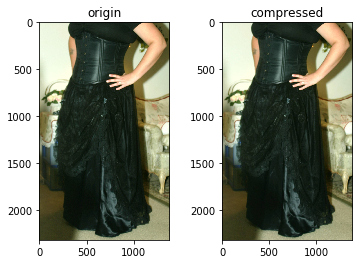

In [539]:
for idx, path in enumerate(amazon_evallog['image_path'][375:1200]):
    img = Image.open(path)
    if path in ref.keys():
        if 'ref_label' not in ref[path].keys():continue
        gt_result = ref[path]['ref_label']
    else:
        error_code, results, size = amazon.recognize(img, 75)
        gt_result = results[0]['keyword']
    
    error_code, results, size = amazon.recognize(img, 25)
    curr_results = [result['keyword'] for result in results]
    if not gt_result in curr_results:
        print(idx, gt_result, curr_results, path)
        figure()
        subplot(121)
        imshow(img)
        title("origin")
        subplot(122)
        imshow(compress(img, 70))
        title("compressed")
        break

#### Plot matrix comparison

In [195]:
facepp.recognize(Image.open("/home/hsli/webdav_pearbox/baidu/chameleon_q75.jpeg"), 5)

(2, [{'keyword': '', 'score': 1e-06}], 5092)

In [193]:
for agent in [baidu, facepp, amazon]:
    for path in [
#                  "/home/hsli/webdav_pearbox/amazon/leopard_25.jpeg",
#                  "/home/hsli/webdav_pearbox/amazon/leopard_55.jpeg",
                 "/home/hsli/webdav_pearbox/amazon/leopard_75.jpeg",
#                  "/home/hsli/webdav_pearbox/baidu/chameleon_q25.jpeg",
#                  "/home/hsli/webdav_pearbox/baidu/chameleon_q55.jpeg",
                 "/home/hsli/webdav_pearbox/baidu/chameleon_q75.jpeg",
#                  "/home/hsli/webdav_pearbox/face++/donut_q25.jpeg",
#                  "/home/hsli/webdav_pearbox/face++/donut_q55.jpeg",
                 "/home/hsli/webdav_pearbox/face++/donut_q75.jpeg"
                 ]:
        for quality in [75, 55, 25]:
            img = Image.open(path)
            error_code, results, size = agent.recognize(img, quality)
            print("%s %s %s:%s" % (agent.api_name, path.split("/")[-1].split("_")[0], quality, results))

baidu leopard 75:[{'keyword': '美洲虎', 'score': 0.746613, 'root': '动物-哺乳动物'}, {'keyword': '鸟类', 'score': 0.498015, 'root': '动物-其他'}, {'keyword': '沙发', 'score': 0.330641, 'root': '商品-电脑办公'}, {'keyword': '花豹', 'score': 0.172158, 'root': '动物-哺乳类'}, {'keyword': '波斯豹', 'score': 0.012758, 'root': '动物-哺乳动物'}]
baidu leopard 55:[{'keyword': '美洲虎', 'score': 0.688036, 'root': '动物-哺乳动物'}, {'keyword': '鸟类', 'score': 0.471692, 'root': '动物-其他'}, {'keyword': '花豹', 'score': 0.307165, 'root': '动物-哺乳类'}, {'keyword': '沙发', 'score': 0.160435, 'root': '商品-电脑办公'}, {'keyword': '包', 'score': 0.011267, 'root': '商品-箱包'}]
baidu leopard 25:[{'keyword': '美洲虎', 'score': 0.497804, 'root': '动物-哺乳动物'}, {'keyword': '鸟类', 'score': 0.352046, 'root': '动物-其他'}, {'keyword': '花豹', 'score': 0.236093, 'root': '动物-哺乳类'}, {'keyword': '沙发', 'score': 0.119985, 'root': '商品-电脑办公'}, {'keyword': '床单', 'score': 0.00806, 'root': '商品-床上用品'}]
baidu chameleon 75:[{'keyword': '变色蜥', 'score': 0.118688, 'root': '动物-爬行动物'}, {'keyword': '变色龙', 'sc

## Scene

In [6]:
# reference dict
ref_dict = {'airfield': 'outdoor-manmade',
'airplane_cabin': 'indoor',
'airport_terminal': 'indoor',
'alcove': 'indoor',
'alley': 'outdoor-manmade',
'amphitheater': 'outdoor-manmade',
'amusement_arcade': 'indoor',
'amusement_park': 'outdoor-manmade',
'apartment_building': 'outdoor-manmade',
'aquarium': 'indoor',
'aqueduct': 'outdoor',
'arcade': 'indoor',
'arch': 'outdoor-manmade',
'archaelogical_excavation': 'outdoor-manmade',
'archive': 'indoor',
'arena': 'indoor',
'army_base': 'outdoor-manmade',
'art_gallery': 'indoor',
'art_school': 'indoor',
'art_studio': 'indoor',
'artists_loft': 'indoor',
'assembly_line': 'indoor',
'athletic_field': 'outdoor-manmade',
'atrium': 'indoor',
'attic': 'indoor',
'auditorium': 'indoor',
'auto_factory': 'indoor',
'auto_showroom': 'indoor',
'badlands': 'outdoor-natural',
'bakery/shop': 'indoor',
'balcony/exterior': 'outdoor-manmade',
'balcony/interior': 'outdoor-manmade',
'ball_pit': 'indoor',
'ballroom': 'indoor',
'bamboo_forest': 'outdoor-natural',
'bank_vault': 'indoor',
'banquet_hall': 'indoor',
'bar': 'indoor',
'barn': 'outdoor',
'barndoor': 'outdoor-manmade',
'baseball_field': 'outdoor-manmade',
'basement': 'indoor',
'basketball_court/indoor': 'indoor',
'bathroom': 'indoor',
'bazaar/indoor': 'indoor',
'bazaar/outdoor': 'outdoor-manmade',
'beach': 'outdoor-natural',
'beach_house': 'outdoor-manmade',
'beauty_salon': 'indoor',
'bedchamber': 'indoor',
'bedroom': 'indoor',
'beer_garden': 'outdoor-manmade',
'beer_hall': 'indoor',
'berth': 'indoor',
'biology_laboratory': 'indoor',
'boardwalk': 'outdoor',
'boat_deck': 'outdoor-manmade',
'boathouse': 'outdoor',
'bookstore': 'indoor',
'booth/indoor': 'indoor',
'botanical_garden': 'outdoor',
'bow_window/indoor': 'indoor',
'bowling_alley': 'indoor',
'boxing_ring': 'indoor',
'bridge': 'outdoor-manmade',
'building_facade': 'outdoor-manmade',
'bullring': 'outdoor-manmade',
'burial_chamber': 'indoor',
'bus_interior': 'indoor',
'bus_station/indoor': [1, 0, 1],
'butchers_shop': 'indoor',
'butte': 'outdoor-natural'}

### Generating dataset

In [54]:
import os
import pickle

In [48]:
folder_names = os.listdir('/home/hsli/gnode02/scene_images/data_large/a')
dataset = []
indoor_dataset = []
outdoor_dataset = []
for folder_name in folder_names:
    file_names = os.listdir('/home/hsli/gnode02/scene_images/data_large/a/' + folder_name)
    for file_name in file_names:
        dataset.append(['/home/hsli/gnode02/scene_images/data_large/a/%s/%s' % (folder_name, file_name), ref_dict[folder_name]])
        if ref_dict[folder_name].find('outdoor') >= 0:
            outdoor_dataset.append(['/home/hsli/gnode02/scene_images/data_large/a/%s/%s' % (folder_name, file_name), ref_dict[folder_name]])
        elif ref_dict[folder_name].find('indoor') >= 0:
            indoor_dataset.append(['/home/hsli/gnode02/scene_images/data_large/a/%s/%s' % (folder_name, file_name), ref_dict[folder_name]])

In [49]:
dataset = np.array(dataset)

In [52]:
indoor_dataset = np.array(indoor_dataset)

In [53]:
outdoor_dataset = np.array(outdoor_dataset)

In [55]:
with open('evaluation_results/places365_indoor_datset.array', 'wb') as f:
    pickle.dump(indoor_dataset, f)

In [56]:
with open('evaluation_results/places365_outdoor_datset.array', 'wb') as f:
    pickle.dump(outdoor_dataset, f)

### Observe results

In [6]:
def list_split(l, size):
    return [l[m:m + size] for m in range(0, len(l), size)]

In [7]:
def front_acc(accs):
    acc_list = []
    temp_list = [np.mean(accs[5:15])]
    for acc in accs:
        temp_list.append(acc)
        acc_list.append(np.sum(temp_list) / len(temp_list))
    return acc_list

In [8]:
baidu_evalog_places365 = rm.load(10)

In [9]:
baidu_evalog_places365.keys()

dict_keys(['image_path', 'size_r', 'acc_r', 'epsilon', 'reward', 'action'])

In [35]:
outdoor_ids = [baidu_evalog_places365['image_path'].index(path) for path in baidu_evalog_places365['image_path'] if ref_dict[path.split('/')[-2]].find('outdoor') >= 0]
len(outdoor_ids)

511

In [34]:
indoor_ids = [baidu_evalog_places365['image_path'].index(path) for path in baidu_evalog_places365['image_path'] if ref_dict[path.split('/')[-2]].find('indoor') >= 0]
len(indoor_ids)

689

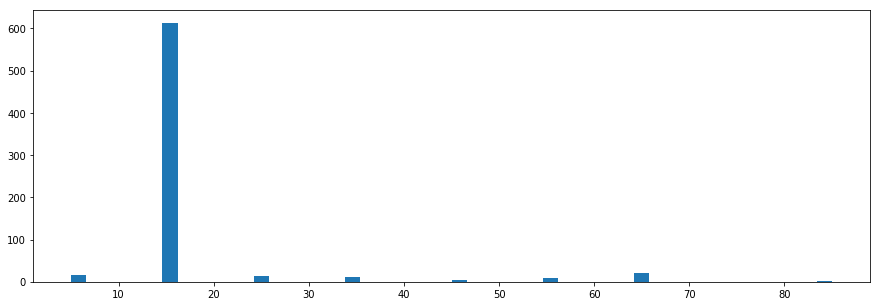

In [32]:
_ = hist(np.array(baidu_evalog_places365['action'])[indoor_ids], bins=50)

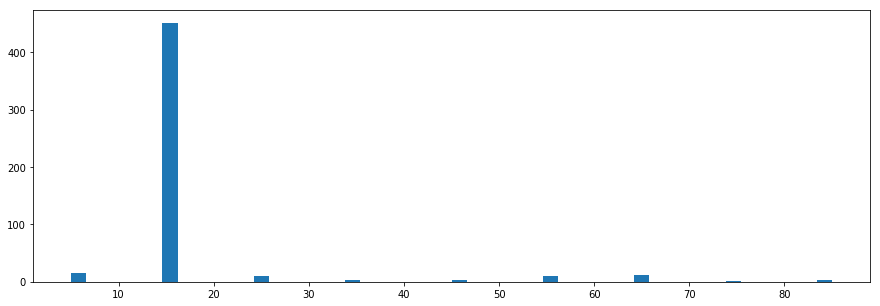

In [33]:
_ = hist(np.array(baidu_evalog_places365['action'])[outdoor_ids], bins=50)

### Observe images

In [11]:
from PIL import Image

In [12]:
high_q_ids = np.where(np.array(baidu_evalog_places365['action'])> 45)

chosen_h_ids = np.random.choice(high_q_ids[0], 15)

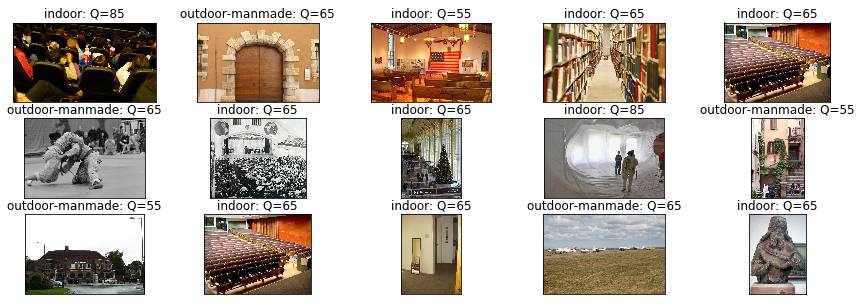

In [15]:
for idx, image_id in enumerate(chosen_h_ids):
    subplot(3, 5, idx+1)
    path = baidu_evalog_places365['image_path'][image_id]
    scene_info = ref_dict[path.split('/')[-2]]
    imshow(Image.open(path))
    title("%s: Q=%s" % (scene_info, baidu_evalog_places365['action'][image_id]))
    xticks([])
    yticks([])

In [16]:
low_q_ids = np.where(np.array(baidu_evalog_places365['action']) < 15)

chosen_l_ids = np.random.choice(low_q_ids[0], 15, replace=False)

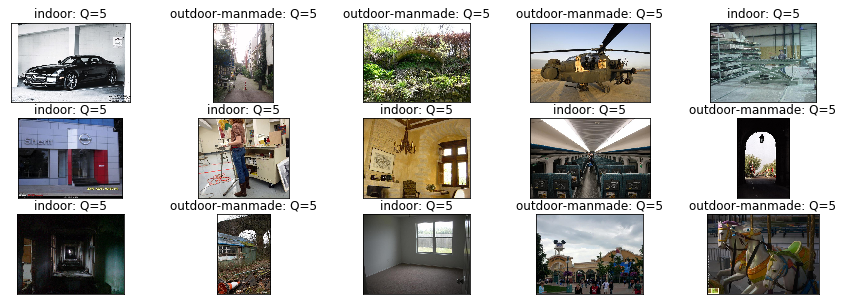

In [17]:
for idx, image_id in enumerate(chosen_l_ids):
    subplot(3, 5, idx+1)
    path = baidu_evalog_places365['image_path'][image_id]
    scene_info = ref_dict[path.split('/')[-2]]
    imshow(Image.open(path))
    title("%s: Q=%s" % (scene_info, baidu_evalog_places365['action'][image_id]))
    xticks([])
    yticks([])

### Agent train on places365 and baidu

In [7]:
def list_split(l, size):
    return [l[m:m + size] for m in range(0, len(l), size)]

In [8]:
def front_acc(accs):
    acc_list = []
    temp_list = [np.mean(accs[5:15])]
    for acc in accs:
        temp_list.append(acc)
        acc_list.append(np.sum(temp_list) / len(temp_list))
    return acc_list

In [9]:
baidu_places365_trainlog = rm.load(11)
baidu_places365_evaluatelog = rm.load(10)

In [10]:
baidu_places365_trainlog.keys()
baidu_places365_evaluatelog.keys()

dict_keys(['size_r', 'reward', 'epsilon', 'action', 'image_path', 'acc_r'])

In [11]:
print(len(baidu_places365_trainlog['reward']), len(baidu_places365_evaluatelog['reward']))

1800 1200


#### Plot reward, accuracy and compression rate

Text(0.5, 1.0, 'reward = top5_accuracy - compression_rate')

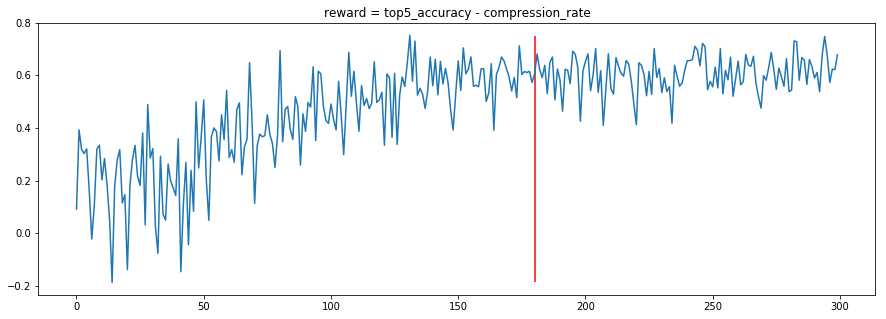

In [18]:
reward_train = [np.mean(item) for item in list_split(baidu_places365_trainlog['reward'], 10)]
reward_eval = [np.mean(item) for item in list_split(baidu_places365_evaluatelog['reward'], 10)]
plot(reward_train + reward_eval)
vlines(x=len(reward_train), ymin=np.min(reward_train), ymax=np.max(reward_eval), colors='r')
title('reward = top5_accuracy - compression_rate')

Text(0.5, 1.0, 'forward accuracy')

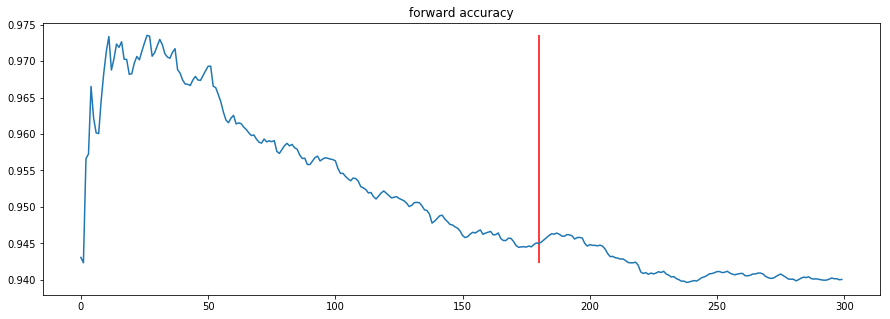

In [19]:
train_acc_track = front_acc(baidu_places365_trainlog['acc_r'])
train_acc = [np.mean(item) for item in list_split(train_acc_track, 10)]
overall_acc = [np.mean(item) for item in list_split(front_acc(baidu_places365_trainlog['acc_r'] + baidu_places365_evaluatelog['acc_r']), 10)]
plot(overall_acc)
vlines(x=len(train_acc), ymin=np.min(train_acc), ymax=np.max(train_acc), colors='r')
title('forward accuracy')

Text(0.5, 1.0, 'real accuracy')

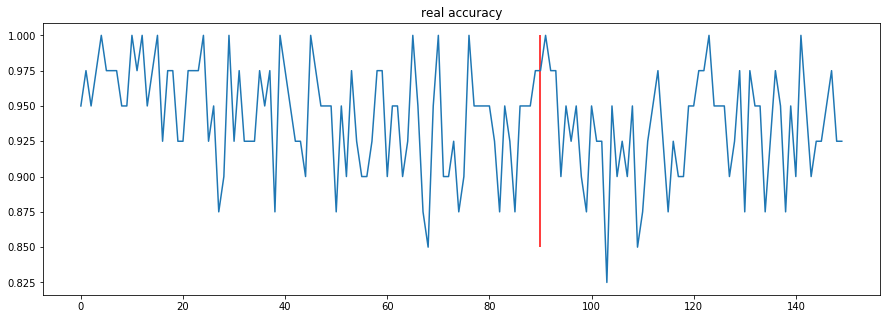

In [20]:
train_acc = [np.mean(item) for item in list_split(baidu_places365_trainlog['acc_r'], 20)]
eval_acc = [np.mean(item) for item in list_split(baidu_places365_evaluatelog['acc_r'], 20)]
plot(train_acc + eval_acc)
vlines(x=len(train_acc), ymin=np.min(train_acc), ymax=np.max(train_acc), colors='r')
title('real accuracy')

Text(0.5, 1.0, 'compression_rate')

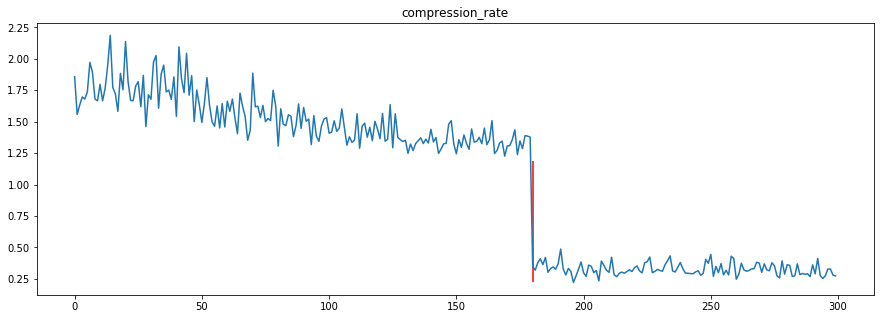

In [21]:
train_size = [np.mean(item) for item in list_split(baidu_places365_trainlog['size_r'], 10)]
eval_size = [np.mean(item) for item in list_split(baidu_places365_evaluatelog['size_r'], 10)]
plot([item + 1 for item in train_size] + eval_size)
vlines(x=len(train_size), ymin=np.min(train_size), ymax=np.max(train_size), color='r')
title('compression_rate')

In [22]:
outdoor_ids = [baidu_places365_evaluatelog['image_path'].index(path) for path in baidu_places365_evaluatelog['image_path'] if ref_dict[path.split('/')[-2]].find('outdoor') >= 0]
len(outdoor_ids)

524

In [23]:
indoor_ids = [baidu_places365_evaluatelog['image_path'].index(path) for path in baidu_places365_evaluatelog['image_path'] if ref_dict[path.split('/')[-2]].find('indoor') >= 0]
len(indoor_ids)

676

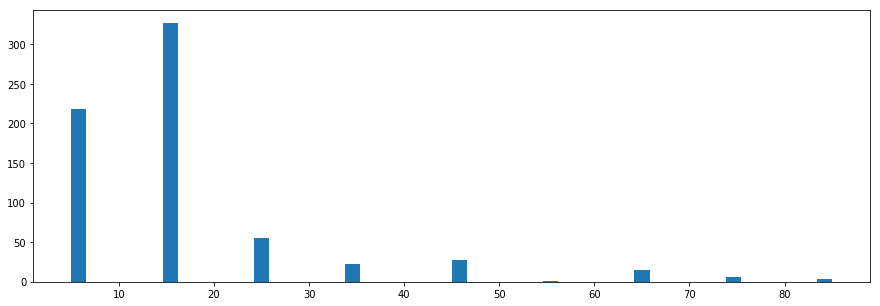

In [24]:
_ = hist(np.array(baidu_places365_evaluatelog['action'])[indoor_ids], bins=50)

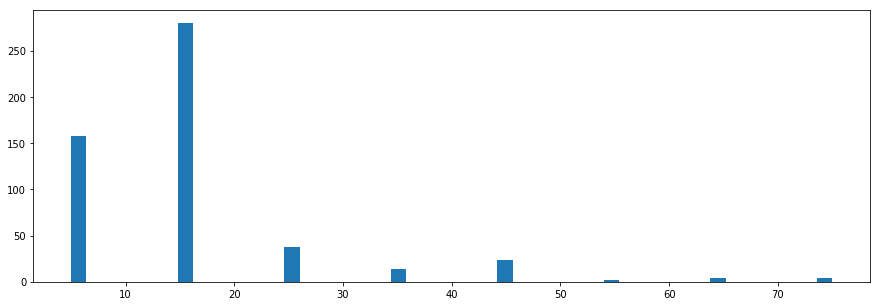

In [25]:
_ = hist(np.array(baidu_places365_evaluatelog['action'])[outdoor_ids], bins=50)

#### Observe images

In [12]:
from PIL import Image

In [13]:
high_q_ids = np.where(np.array(baidu_places365_evaluatelog['action'])> 45)

chosen_h_ids = np.random.choice(high_q_ids[0], 15)

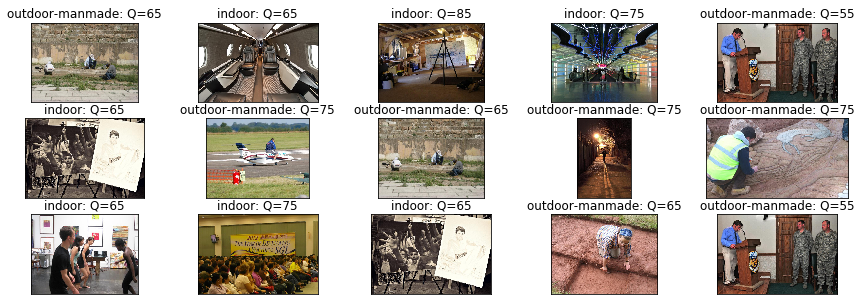

In [14]:
for idx, image_id in enumerate(chosen_h_ids):
    subplot(3, 5, idx+1)
    path = baidu_places365_evaluatelog['image_path'][image_id]
    scene_info = ref_dict[path.split('/')[-2]]
    imshow(Image.open(path))
    title("%s: Q=%s" % (scene_info, baidu_places365_evaluatelog['action'][image_id]))
    xticks([])
    yticks([])

In [15]:
low_q_ids = np.where(np.array(baidu_places365_evaluatelog['action']) < 15)

chosen_l_ids = np.random.choice(low_q_ids[0], 15, replace=False)

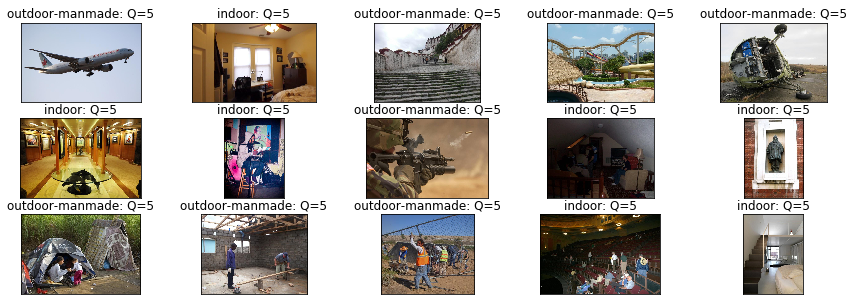

In [16]:
for idx, image_id in enumerate(chosen_l_ids):
    subplot(3, 5, idx+1)
    path = baidu_places365_evaluatelog['image_path'][image_id]
    scene_info = ref_dict[path.split('/')[-2]]
    imshow(Image.open(path))
    title("%s: Q=%s" % (scene_info, baidu_places365_evaluatelog['action'][image_id]))
    xticks([])
    yticks([])

#### Visualize DQN's interest on places365

In [18]:
from visualize_test import Visualizer

In [19]:
visualizer = Visualizer('evaluation_results/agent_DQN_baidu_places365.h5')

In [20]:
high_q_ids = np.where(np.array(baidu_places365_evaluatelog['action'])> 45)

chosen_h_ids = np.random.choice(high_q_ids[0], 20, replace=False)

In [21]:
len(high_q_ids[0])

35

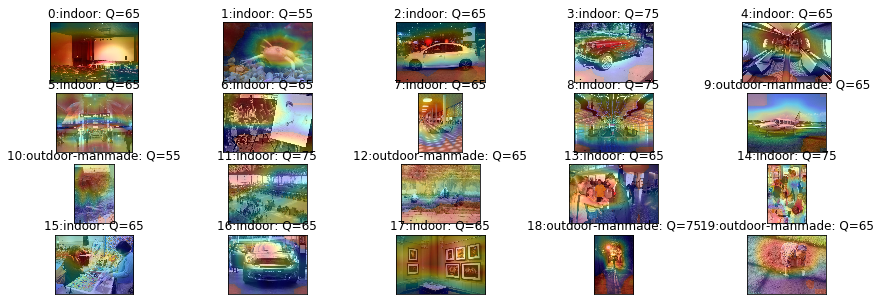

In [24]:
for idx, image_id in enumerate(chosen_h_ids):
    subplot(4, 5, idx+1)
    path = baidu_places365_evaluatelog['image_path'][image_id]
    scene_info = ref_dict[path.split('/')[-2]]
    img_data = visualizer.visualize(path)
    imshow(visualizer.format_img_float(img_data))
    title("%s:%s: Q=%s" % (idx, scene_info, baidu_places365_evaluatelog['action'][image_id]))
    xticks([])
    yticks([])

In [ ]:
low_q_ids = np.where(np.array(baidu_places365_evaluatelog['action']) < 15)

chosen_l_ids = np.random.choice(low_q_ids[0], 15, replace=False)

In [ ]:
for idx, image_id in enumerate(chosen_l_ids):
    subplot(3, 5, idx+1)
    path = baidu_places365_evaluatelog['image_path'][image_id]
    scene_info = ref_dict[path.split('/')[-2]]
    img_data = visualizer.visualize(path)
    imshow(visualizer.format_img_float(img_data))
    title("%s: Q=%s" % (scene_info, baidu_places365_evaluatelog['action'][image_id]))
    xticks([])
    yticks([])

#### Visualize DQN's interest on imagenet （attention）

In [6]:
from visualize_test import Visualizer

Using TensorFlow backend.


In [7]:
evaluate_baidu_imagenet = rm.load(7)

In [8]:
visualizer = Visualizer('evaluation_results/agent_DQN_train_1.6K_baidu.h5')

In [9]:
high_q_ids = np.where(np.array(evaluate_baidu_imagenet['action'])> 65)

chosen_h_ids = np.random.choice(high_q_ids[0], 15, replace=False)

In [10]:
len(high_q_ids[0])

19

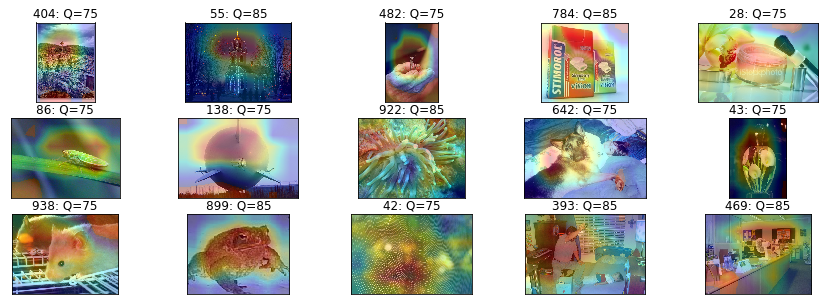

In [11]:
for idx, image_id in enumerate(chosen_h_ids):
    subplot(3, 5, idx+1)
    path = evaluate_baidu_imagenet['image_path'][image_id]
    img_data = visualizer.visualize(path)
    imshow(visualizer.format_img_float(img_data))
    title("%s: Q=%s" % (image_id, evaluate_baidu_imagenet['action'][image_id]))
    xticks([])
    yticks([])

In [12]:
sensetive_images = np.array(evaluate_baidu_imagenet['image_path'])[np.array([784, 752, 28, 138])]

In [13]:
low_q_ids = np.where(np.array(evaluate_baidu_imagenet['action']) < 25)

chosen_l_ids = np.random.choice(low_q_ids[0], 15, replace=False)

In [14]:
len(low_q_ids[0])

820

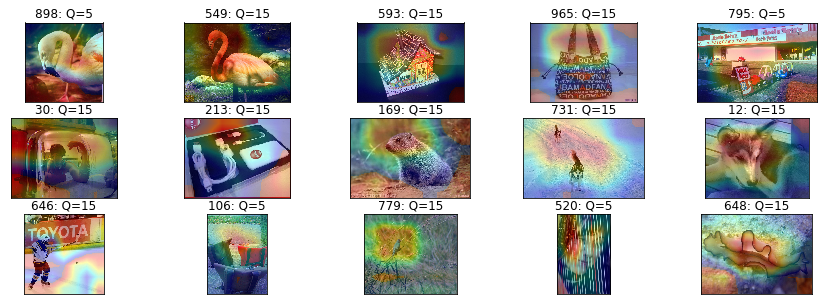

In [15]:
for idx, image_id in enumerate(chosen_l_ids):
    subplot(3, 5, idx+1)
    path = evaluate_baidu_imagenet['image_path'][image_id]
    img_data = visualizer.visualize(path)
    imshow(visualizer.format_img_float(img_data))
    title("%s: Q=%s" % (image_id, evaluate_baidu_imagenet['action'][image_id]))
    xticks([])
    yticks([])

In [16]:
robust_images = np.array(evaluate_baidu_imagenet['image_path'])[np.array([316, 884, 500, 191])]

In [17]:
from PIL import Image

In [32]:
%matplotlib qt5

([], <a list of 0 Text yticklabel objects>)

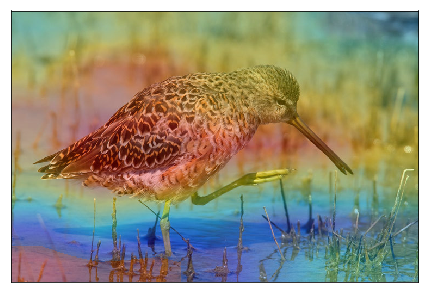

In [35]:
path = robust_images[3]
image_data = visualizer.visualize(path)
imshow(visualizer.format_img_8bit(image_data))
image = visualizer.format_img_8bit(image_data)
xticks([])
yticks([])
# xlabel("Q = %s" % evaluate_baidu_imagenet['action'][316])

In [36]:
Image.fromarray(image).show()

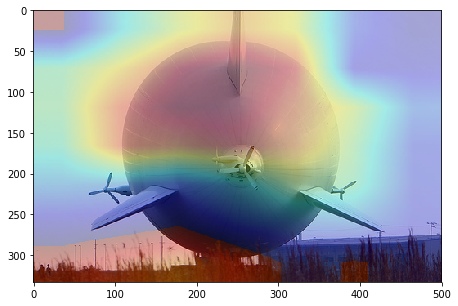

In [26]:
for path in sensetive_images:
    image_data = visualizer.visualize(path)
    imshow(visualizer.format_img_float(image_data))

In [25]:
for path in robust_images:
    Image.open(path).show()

## Running retrain mechanism

In [40]:
%matplotlib inline

In [6]:
running_log = rm.load(21)

In [7]:
running_log.keys()

dict_keys(['ref_size', 'size_reward', 'explor_rate', 'recent_reward', 'agent_epsilon', 'accuracy', 'step_count', 'reward', 'comp_size', 'agent_accuracy', 'upload_size', 'status', 'action', 'recent_accuracy', 'image_path'])

Text(0.5, 1.0, "Agent's actions")

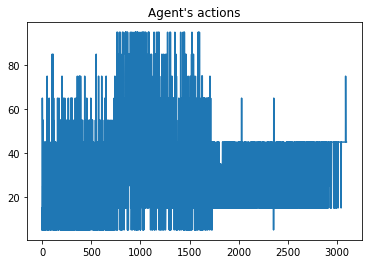

In [43]:
plot(running_log['action'])
title("Agent's actions")

In [44]:
imagenet_actions = np.array(running_log['action'][:720])
DNIM_actions = np.array(running_log['action'][1670:])

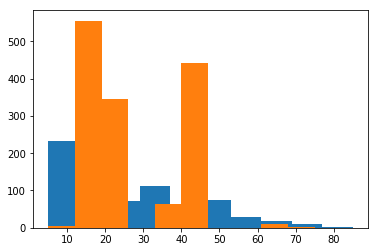

In [45]:
imagenet_hist = hist(imagenet_actions, bins=10)
DNIM_hist = hist(DNIM_actions, bins=10)

### Plot dataset variations (dataset_change.pdf)

In [49]:
%matplotlib qt5

In [50]:
bar([i - 1.5 for i in np.arange(5, 105, 10)], np.array(imagenet_hist[0]) / 1000, width=3, label='ImageNet images', color='lightsteelblue')
bar([i + 1.5 for i in np.arange(5, 105, 10)], np.array(DNIM_hist[0]) / 1000, width=3, label='DNIM images', color='darksalmon')
xticks([i for i in np.arange(5, 105, 10)])
xlabel("Compression level (Q for JPEG)")
ylabel(r"Counts ($\times10^3$)")
legend()

plt.subplots_adjust(top=1.0,
                    bottom=0.235,
                    left=0.115,
                    right=0.995,
                    hspace=0.2,
                    wspace=0.2)

### Try retrain trigger

In [17]:
from collections import defaultdict

In [23]:
agent_log = rm.load(21)

In [24]:
agent_memory = defaultdict(list)

In [25]:
estimate_id = np.where(np.array(agent_log['status']) == 2)

In [26]:
for key in agent_log.keys():
    agent_memory[key] = np.array(agent_log[key])[estimate_id]

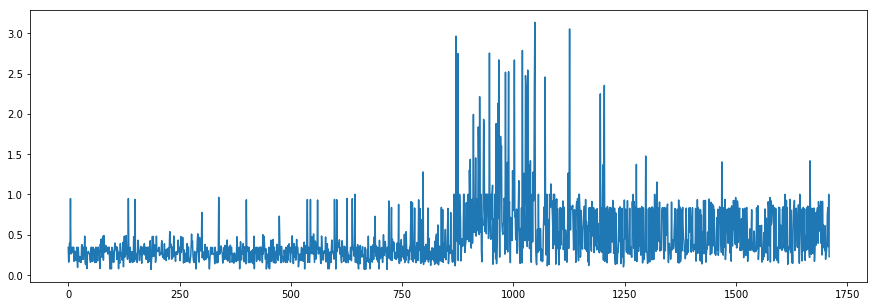

In [29]:
plot(agent_log['size_reward'])
# hlines(y=2, xmin=0, xmax=len(agent_log['retrain_index']))

In [30]:
np.mean(agent_log['size_reward'][-500:])

0.5231583859451265

In [37]:
np.mean(agent_log['accuracy'][-500:])

0.974

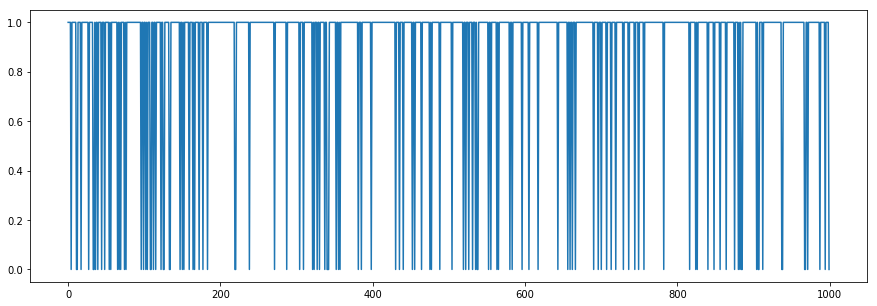

In [42]:
plot(agent_log['agent_accuracy'][-1000:])

In [38]:
q25 = rm.load(23)

In [40]:
np.mean(q25['agent_accuracy'])

0.9376884422110553

In [41]:
np.mean(q25['size_reward'])

0.44228567978214384

In [84]:
class KalmanFilter():
    def __init__(self, system_variance, measure_variance, initial_guest, initial_postori_error):
        self.xhat = [initial_guest]
        self.P = [initial_postori_error]
        self.Q = system_variance
        self.R = measure_variance
        
        self.xhatminus = []
        self.Pminus = []
        self.K = []
        self.z = []
        
        self.step_count = 0
        
    def filt(self, z):
        self.z.append(z)
        self.step_count += 1
        # time udate
        self.xhatminus.append(self.xhat[-1])
        self.Pminus.append(self.P[-1] + self.Q)  # Here P indicates P^2, therefore no square
        
        # measurement update
        self.K.append(self.Pminus[-1] / (self.Pminus[-1] + self.R))
        self.xhat.append(self.xhatminus[-1] + self.K[-1] * (self.z[-1] - self.xhatminus[-1]))
        self.P.append((1 - self.K[-1]) * self.Pminus[-1])  # Here P indicates P^2, therefore no sqrt
        
        return self.xhat[-1]

### Build Kalman Filter to smooth retrain_index

In [85]:
Kfilter = KalmanFilter(system_variance=1e-5, 
                       measure_variance=0.1**2, 
                       initial_guest=2.0, 
                       initial_postori_error=1.0)

In [86]:
preds = []
inputs = []
for num in agent_log['retrain_index']:
    inputs.append(num)
    preds.append(Kfilter.filt(num))

Text(0, 0.5, 'Voltage')

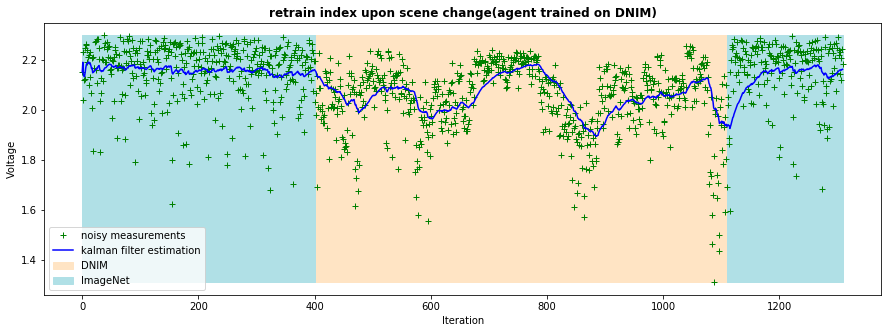

In [87]:
# plot my kalman filter
plt.figure()
l1 = plt.plot(inputs,'k+',label='noisy measurements', linewidth=0.1, color='g')
l2 = plt.plot(preds,'b-',label='kalman filter estimation')
r1 = plt.fill_betweenx(x1=400, x2=len(agent_log['retrain_index'])-200, y=[np.min(agent_log['retrain_index']),np.max(agent_log['retrain_index'])], color='bisque', label="DNIM")
r2 = plt.fill_betweenx(x1=0, x2=400, y=[np.min(agent_log['retrain_index']),np.max(agent_log['retrain_index'])], color='powderblue', label="ImageNet")
r3 = plt.fill_betweenx(x1=len(agent_log['retrain_index'])-200, x2=len(agent_log['retrain_index']), y=[np.min(agent_log['retrain_index']),np.max(agent_log['retrain_index'])], color='powderblue', label="ImageNet")
lns = l1+l2+[r1, r2]
plt.legend(lns, [l.get_label() for l in lns])
plt.title('retrain index upon scene change(agent trained on DNIM)', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Voltage')

# plt.figure()
# valid_iter = range(1,len(agent_log['retrain_index'])) # Pminus not valid at step 0
# plt.plot(valid_iter,np.array(Kfilter.Pminus)[valid_iter],label='a priori error estimate')
# plt.title('Estimated $\it{\mathbf{a \ priori}}$ error vs. iteration step', fontweight='bold')
# plt.xlabel('Iteration')
# plt.ylabel('$(Voltage)^2$')
# plt.setp(plt.gca(),'ylim',[0,.01])
# plt.show()

In [95]:
preds = []
inputs = []
for num in agent_log['retrain_index']:
    inputs.append(num)
    preds.append(Kfilter.filt(num))

Text(0, 0.5, 'Voltage')

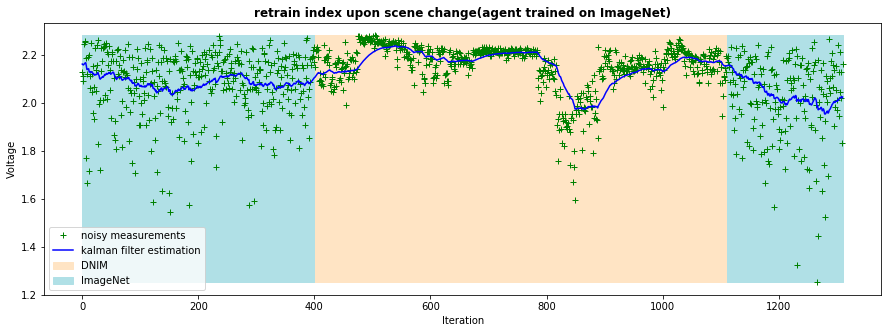

In [97]:
# plot my kalman filter
plt.figure()
l1 = plt.plot(inputs,'k+',label='noisy measurements', linewidth=0.1, color='g')
l2 = plt.plot(preds,'b-',label='kalman filter estimation')
r1 = plt.fill_betweenx(x1=400, x2=len(agent_log['retrain_index'])-200, y=[np.min(agent_log['retrain_index']),np.max(agent_log['retrain_index'])], color='bisque', label="DNIM")
r2 = plt.fill_betweenx(x1=0, x2=400, y=[np.min(agent_log['retrain_index']),np.max(agent_log['retrain_index'])], color='powderblue', label="ImageNet")
r3 = plt.fill_betweenx(x1=len(agent_log['retrain_index'])-200, x2=len(agent_log['retrain_index']), y=[np.min(agent_log['retrain_index']),np.max(agent_log['retrain_index'])], color='powderblue', label="ImageNet")
lns = l1+l2+[r1, r2]
plt.legend(lns, [l.get_label() for l in lns])
plt.title('retrain index upon scene change(agent trained on ImageNet)', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Voltage')

# plt.figure()
# valid_iter = range(1,len(agent_log['retrain_index'])) # Pminus not valid at step 0
# plt.plot(valid_iter,np.array(Kfilter.Pminus)[valid_iter],label='a priori error estimate')
# plt.title('Estimated $\it{\mathbf{a \ priori}}$ error vs. iteration step', fontweight='bold')
# plt.xlabel('Iteration')
# plt.ylabel('$(Voltage)^2$')
# plt.setp(plt.gca(),'ylim',[0,.01])
# plt.show()

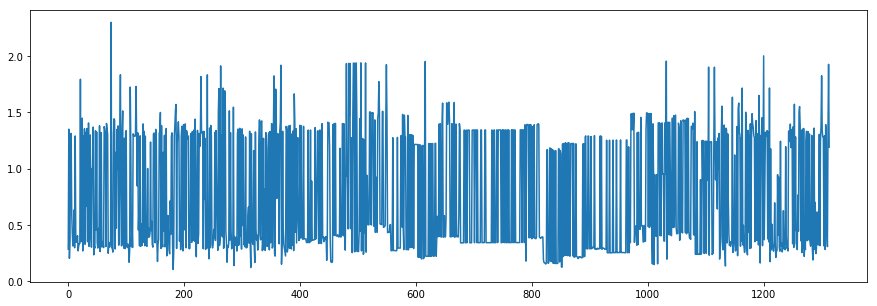

In [49]:
plot([agent_log['size_reward'][idx] + agent_log['status'][idx] - 1 for idx in range(len(agent_log['size_reward']))])

In [38]:
np.mean([agent_log['size_reward'][idx] + agent_log['status'][idx] - 1 for idx in range(len(agent_log['size_reward']))])

0.878247904367188

In [41]:
idx = np.where(np.array(agent_log['action']) > 20)

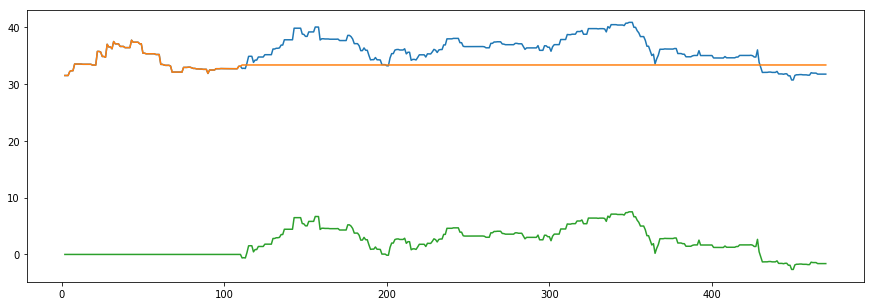

In [13]:
l1 = 0.8 * np.array(agent_log['recent_action']) + 30 * np.array(agent_log['recent_reward'])
l2 = 0.8 * np.array(agent_log['initial_action']) + 30 * np.array(agent_log['initial_reward'])
plot(l1)
plot(l2)
plot(l1 - l2)

### Plot retrain figures

In [8]:
dnim_on_imagenet = rm.load(21)

In [9]:
agent_memory_acc = np.array(dnim_on_imagenet['recent_accuracy'])[np.where(np.array(dnim_on_imagenet['status']) > 1)[0]]

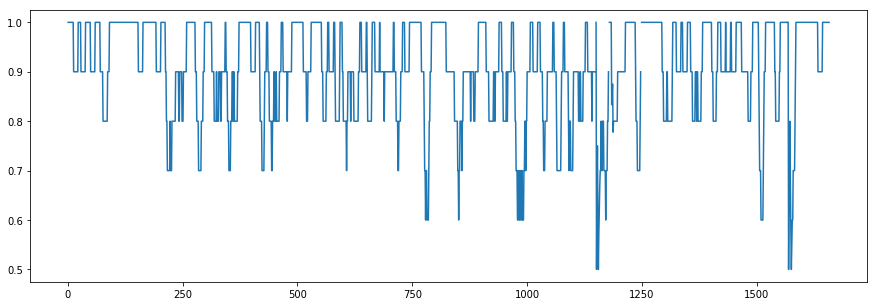

In [10]:
plot(agent_memory_acc)

#### Test gradients related exploration rate

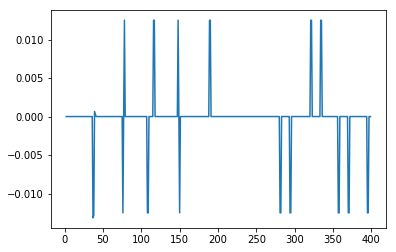

In [630]:
plot(np.gradient(agent_memory_acc[:400]))

In [686]:
np.gradient([1,2])

array([1., 1.])

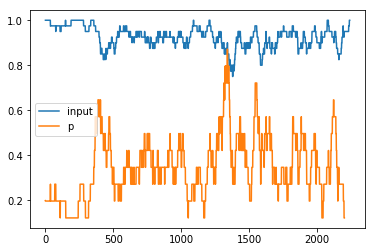

In [688]:
recent_accuracy = []
gradients = []
p_list = []
p = 0.2
factor = 3
for acc in agent_memory_acc:
    recent_accuracy.append(acc)
    if len(recent_accuracy) >= 40:
        grad = np.gradient(recent_accuracy)[-1]
        gradients.append(grad)
        p = p if np.isnan(grad) else p - factor * grad
        p_list.append(p)

# plot(gradients, label='local gradients')
plot(agent_memory_acc, label='input')
# plot(np.gradient(agent_memory_acc[:400]), label='real gradients')
plot(p_list, label='p')

legend()

#### Plot figures

In [696]:
def recent(accs, recent_zone):
    if len(accs) < recent_zone:
        return np.mean(accs)
    else:
        return np.mean(accs[-recent_zone:])

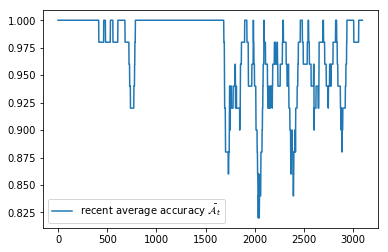

In [708]:
plot([recent(dnim_on_imagenet['accuracy'][:idx+1], 50) for idx in range(len(dnim_on_imagenet['accuracy']))], label=r"recent average accuracy $\bar{\mathcal{A}_t}$")
legend()

In [808]:
np.where(np.array(dnim_on_imagenet['status'][:1700]) == 3)[0][np.array([0, -1])]

array([ 740, 1670])

In [776]:
len(dnim_on_imagenet['status'])

3097

In [737]:
recent_accuracies = [recent(dnim_on_imagenet['accuracy'][:idx+1], 50) for idx in range(len(dnim_on_imagenet['accuracy']))]
estimate_probs = dnim_on_imagenet['explor_rate']

In [810]:
upload_sizes = dnim_on_imagenet['upload_size']

recent_upload_sizes = np.array([recent(upload_sizes[:idx+1], 10) for idx in range(len(upload_sizes))])
scaled_recent_sizes = recent_upload_sizes / np.max(recent_upload_sizes)

/home/hsli/anaconda2/envs/tensorflow18_p35/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


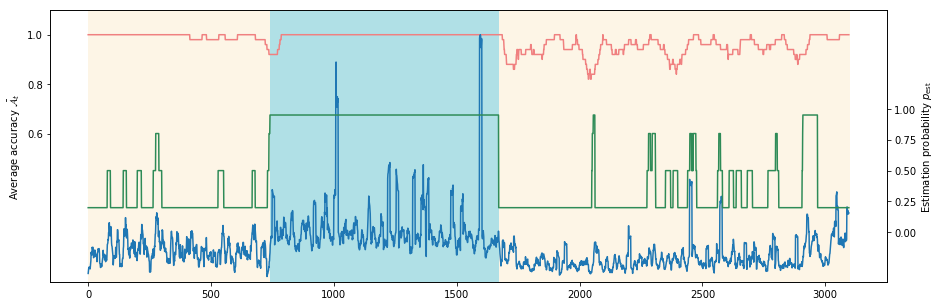

In [811]:
fig = plt.figure()

r1 = plt.fill_betweenx(x1=0, x2=740, y=[-0.4,1.8], color='oldlace', label="inference")
r2 = plt.fill_betweenx(x1=741, x2=1670, y=[-0.4, 1.8], color='powderblue', label="retrain")
r3 = plt.fill_betweenx(x1=1671, x2=3097, y=[-0.4, 1.8], color='oldlace', label="inference")

ax = fig.add_subplot(111)
l1 = ax.plot(recent_accuracies, label=r"recent average accuracy $\bar{\mathcal{A}_t}$", color="lightcoral")
ls = ax.plot(scaled_recent_sizes)

ax.set_ylabel(r"Average accuracy $\bar{\mathcal{A}_t}$")
ax.set_ylim(0, 1.1)
ax.set_yticks(ax.get_yticks()[3:-1])

# ax.set_xticks([1,2,3,4])
# ax.set_xticklabels(["Benchmark Q=75", "Baidu Vision", "Face++", "Amazon Rekognition"], fontdict=font)

ax2 = ax.twinx()
l2 = ax2.plot(estimate_probs, label=r"estimation probability $p_{\rm est}$", color="seagreen")
ax2.set_ylabel(r"Estimation probability $p_{\rm est}$")
ax2.set_ylim(-0.4, 1.8)
ax2.set_yticks(ax2.get_yticks()[2:-4])
# ax2.grid(linestyle='--')


# fig.legend([b11, b21], ["Average Size", "Relative Accuracy"], loc=8, ncol=2)

#### Draw in smooth form (running-retrain.pdf)

In [11]:
fine_grain_accs = dnim_on_imagenet['accuracy']
fine_grain_probs = dnim_on_imagenet['explor_rate']
fine_grain_sizes = dnim_on_imagenet['upload_size'][:1670] + dnim_on_imagenet['comp_size'][1670:]
fine_grain_refsizes = dnim_on_imagenet['ref_size']

In [12]:
smooth_window = 30

In [13]:
print("max upload size: %s\nmax ref size: %s" % (np.max(fine_grain_sizes), np.max(fine_grain_refsizes)))

max upload size: 2524540
max ref size: 954917


In [17]:
aver_accs = [np.mean(item) for item in list_split(fine_grain_accs, smooth_window)]
aver_probs = [np.mean(item) for item in list_split(fine_grain_probs, smooth_window)]
aver_sizes = [np.mean(item) for item in  list_split(fine_grain_sizes, smooth_window)]
aver_ref_sizes = [np.mean(item) for item in  list_split(fine_grain_refsizes, smooth_window)]

norm_sizes = np.array(aver_sizes) / 200000
norm_refsizes = np.array(aver_ref_sizes) / 150000

In [18]:
720 / smooth_window

24.0

In [19]:
741 / smooth_window

24.7

In [20]:
1670 / smooth_window

55.666666666666664

In [44]:
len(aver_accs)

104

In [40]:
retrain_y1 = np.max([norm_sizes[25:56], norm_refsizes[25:56]], axis=0)
len(retrain_y1)

31

In [37]:
[i for i in np.arange(0,5,1)]

[0, 1, 2, 3, 4]

In [67]:
%matplotlib qt5

In [22]:
%matplotlib inline

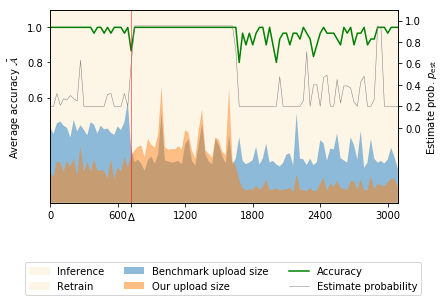

In [45]:
fig = plt.figure()

ax = fig.add_subplot(111)

r1 = ax.fill_between(x=[i for i in np.arange(0,26,1)], y1=norm_refsizes[:26], y2=1.8, color='oldlace', label="inference")
r2 = ax.fill_between(x=[i for i in np.arange(25,56,1)], y1=retrain_y1, y2=1.8, color='oldlace', label="inference")
r3 = ax.fill_between(x=[i for i in np.arange(55,104,1)], y1=norm_refsizes[55:], y2=1.8, color='oldlace', label="inference")

# r1 = ax.fill_betweenx(x1=0, x2=740 / smooth_window, y=[-0.4,1.8], color='oldlace', label="inference")
# r2 = ax.fill_betweenx(x1=741 / smooth_window, x2=1670 / smooth_window, y=[-0.4, 1.8], color='powderblue', label="retrain")
# r3 = ax.fill_betweenx(x1=1671 / smooth_window, x2=3097 / smooth_window, y=[-0.4, 1.8], color='oldlace', label="inference")

l1 = ax.plot(aver_accs, label=r"recent average accuracy $\bar{\mathcal{A}_t}$", color="green")


rs1 = ax.fill_between(x=[i for i in range(104)], y1=0, y2=norm_refsizes, alpha=0.5, label="ref_size")
rs2 = ax.fill_between(x=[i for i in range(104)], y1=0, y2=norm_sizes, alpha=0.5, label="upload_size")

ax.set_ylabel(r"Average accuracy $\bar{\mathcal{A}}$")
ax.set_ylim(0, 1.1)
ax.set_yticks(ax.get_yticks()[3:-1])

ax2 = ax.twinx()
l2 = ax2.plot(aver_probs, label=r"estimation probability $p_{\rm est}$", color="gray", linewidth=0.5)
ax2.set_ylabel(r"Estimate prob. $p_{\rm est}$")
ax2.set_ylim(-0.7, 1.1)
ax2.set_yticks(ax2.get_yticks()[4:-1])

ax2.vlines(x=24, ymin=-0.7, ymax=1.8, linestyles='-', linewidth=0.5, color='r')

plt.xlim(0, 103)
ax2.set_xlabel("steps")

ax2.set_xticks([0, 20, 24, 40, 60, 80, 100])
ax2.set_xticklabels(["0", "600", r"$\Delta$", "1200", "1800", "2400", "3000"])

plt.setp(ax2.get_xticklabels(), rotation=90)

fig.legend([r1, r2, rs1, rs2] + l1 + l2, 
           ["Inference", "Retrain", "Benchmark upload size", "Our upload size", "Accuracy", "Estimate probability"], 
           loc=8, ncol=3)

plt.subplots_adjust(top=1.0,
                    bottom=0.33,
                    left=0.105,
                    right=0.91,
                    hspace=0.2,
                    wspace=0.2)

### MDMI (Minus-decrease-multiple-increase) Design

In [494]:
np.random.seed(2)

In [495]:
def recent_acc(accs, recent_zone):
    if len(accs) < recent_zone:
        return np.mean(accs)
    else:
        return np.mean(accs[-recent_zone:])

In [496]:
p = 0.1
p_min = 0.1
p_dec = 0.001
p_mul = 1.8
est_accs = []
est_log = []
p_list = []
recent_accs = []
for acc in dnim_on_imagenet['agent_accuracy']:
    if np.random.uniform() < p:
        est_accs.append(acc)
        est_log.append(acc)
        if acc == 0:
            p = 1 if p * p_mul > 1 else p * p_mul
    else:
        p = p_min if p - p_dec < p_min else p - p_dec
        est_accs.append(-1)
    p_list.append(p)
    recent_accs.append(recent_acc(est_log, 40))

/home/hsli/anaconda2/envs/tensorflow18_p35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/hsli/anaconda2/envs/tensorflow18_p35/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


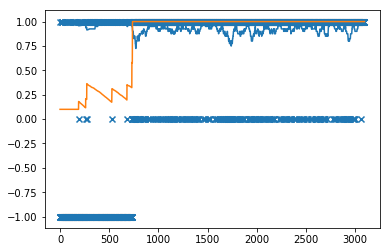

In [497]:
scatter([i for i in range(len(est_accs))], est_accs, marker='x')
plot(recent_accs)
plot(p_list)
# ylim(-0.2, 1.2)

In [393]:
def front_acc(accs):
    acc_list = []
    temp_list = [np.mean(accs[100])]
    for acc in accs:
        temp_list.append(acc)
        acc_list.append(np.sum(temp_list) / len(temp_list))
    return acc_list

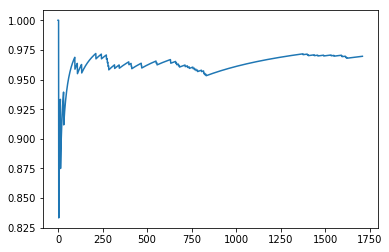

In [70]:
plot(front_acc(dnim_on_imagenet['accuracy']))

In [88]:
np.mean(dnim_on_imagenet['accuracy'][-1000:])

0.977

In [98]:
np.mean(np.array(dnim_on_imagenet['upload_size'])[1300:] / np.array(dnim_on_imagenet['ref_size'])[1300:])

1.1042746849514093

0.49159984037319837

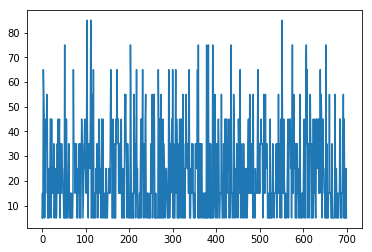

In [87]:
plot(dnim_on_imagenet['action'][:700])